<a href="https://colab.research.google.com/github/Akulamax/Machine-Learning/blob/master/LoanDefaultPrediction_with_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузим все необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

In [ ]:
X = pd.read_csv("applicationdata.csv")
X.sample(5)

,CustomerID,LoanType,Reason,Application.Date,Employment.Length,Employment.Sector,RequestedAmount,OfferedAmount,FundedAmount,Duration,...,Transport_repaymentcapacity_ratio,Income_MonthlyRepayments_ratio,NonDiscretionarySpending_MonthlyRepayments_ratio,DiscretionarySpending_MonthlyRepayments_ratio,RepaymentCapacity_MonthlyRepayments_ratio,MaxCdia,Isdefault,Isapproved,Inrange,Hasjson
8252,244103.0,New,Home renovations,2017-08-18 13:14:04.770,More than 1 year,"Mining, Oil & Gas",6000.0,5300.0,5300.0,30 months,...,0.0212,16.7801,6.5252,8.3288,1.9260,0.0,0.0,1.0,1.0,1.0
11430,224212.0,New,"Consolidate debt (e.g. store card, loan and cr...",2017-03-29 11:26:27.767,3 months to 1 year,IT & Telecommunications,10000.0,5000.0,5000.0,24 months,...,0.0000,9.0733,6.0636,1.8057,1.2040,5.0,0.0,1.0,1.0,1.0
11498,212851.0,Repeat,Purchase,2017-03-31 16:25:48.700,3 months to 1 year,Automotive,4500.0,2500.0,2500.0,12 months,...,0.0000,7.3705,0.3131,0.4490,6.6083,120.0,1.0,1.0,1.0,1.0
6523,248888.0,New,Home appliances or furniture,2017-06-29 15:39:39.857,Less than 3 months,Other,3000.0,2300.0,2300.0,24 months,...,0.0071,3.4932,0.7967,1.0891,1.6073,73.0,1.0,1.0,1.0,1.0
10874,214033.0,New,Purchase,2017-02-26 11:06:46.730,More than 1 year,Admin/Office support,3000.0,3000.0,3000.0,12 months,...,0.0000,10.6480,1.7538,2.6467,6.2474,180.0,1.0,1.0,1.0,1.0


# Отступ ⬇

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12982 entries, 0 to 12981
Columns: 216 entries, CustomerID to Hasjson
dtypes: float64(194), object(22)
memory usage: 21.4+ MB


In [ ]:
features = X.columns.values
features.shape[0]

216

Видно, что признаков очень много, но возникает ощущение, что далеко не все из них полезны

In [ ]:
X = X.drop(index=X[X.isna().sum(axis=1) >= 100].index)

In [ ]:
#X = df1.drop("Isdefault", axis=1)
#y = df1["Isdefault"]

In [ ]:
#y = y.iloc[:-2].astype(int)
X = X.iloc[:-2, :]

In [ ]:
print("Столбец количество пропусков количество уникальных значений")
for col in X:
    print(col, X[col].isna().sum(), X[col].nunique())

Столбец количество пропусков количество уникальных значений
CustomerID 0 12279
LoanType 0 2
Reason 0 894
Application.Date 0 12957
Employment.Length 47 3
Employment.Sector 57 26
RequestedAmount 0 95
OfferedAmount 0 86
FundedAmount 0 87
Duration 0 34
Age 0 48
EmailDomain 0 555
Residential.Status 7 3
Sex 0 2
Marital.Status 136 3
Dependents 136 4
City 2 4177
State 0 9
PostalCode 0 1569
Pay.Frequency 0 3
Product 0 2
Risk.Rating 0 7
Employment.Type 0 5
Requested.Duration 0 39
ArrearsLevel 5889 4
IsWrittenOff 0 2
age.of.file 150 2686
age.of.subject 150 2614
time.at.address 150 1756
time.at.employer 1106 908
defaults 150 3
total.value.of.outstanding.defaults 2971 259
defaults.paid 150 3
defaults.12 150 3
time.since.last.default 12348 128
credit.enquiries.1 150 9
credit.enquiries.3 150 17
credit.enquiries.6 150 21
credit.enquiries.12 150 28
credit.enquiries.60 150 50
time.since.last.enquiry 673 902
telco.and.utility.defaults 150 3
telco.and.utility.defaults.12 150 3
telco.and.utility.enquiries 

#### ***Видно***, что всякие признаки, названия которых оканчиваются на num, CC, PL, Tran и ratio имеют непривлекательно много пропусков, к тому же, для CC, PL, Tran префиксы совпадают для признаков, оканчивающихся на All, так что возможно, что это по сути одно и то же, просто с разных сторон. Для All очень мало пропусков, так что сначала мы и возьмем в нашу модель

In [ ]:
bad_features = []
for col_name in X.columns:
    if (col_name.endswith("num") or col_name.endswith("_CC") or col_name.endswith("_PL") or
        col_name.endswith("_Tran") or col_name.endswith("_ratio")):
        bad_features.append(col_name)
X.drop(columns=bad_features, inplace=True)

## Мое предположение, что от адреса электронной почты, postal code и applycationDate таргет слабо зависит, можно их дропнуть(сделаем из даты 2 новых столбца - год и месяц), а так же удалим признаки, способствующих переобучению (по заявлению автора статьи) IsWrittenOff, MaxCdia, а так же последние три признака - у них всего 1 уникальное значение, это ни о чем не скажет нашей модели

## Второе замечание - уникальных ID всего 12300, надо с ними разобраться..

In [ ]:
X['Year'] = X['Application.Date'].apply(lambda x : int(x[:4]))
X['Month'] = X['Application.Date'].apply(lambda x : int(x[5:7]))
X.drop("Application.Date", axis=1, inplace=True)

In [ ]:
X.drop(columns=["PostalCode", "contributing.factors", "TDatePart","time.since.last.default",
                "IsWrittenOff", "MaxCdia", "Isapproved", "Inrange", "Hasjson"], inplace=True)

Теперь нам предстоит работа с пропусками - попробуем по максимуму разобраться и адекватно заполнить пропуски - потому что тут есть столбцы с вполне понятными заменами для NaN

In [ ]:
# этот код показывает, сколько будет пропусков в каждом столбце (числовом), если в нем убрать строки с NaN'овыми age.of.file
# аналогично можно поступить с окончанием ratio и All
# в итоге, мы потеряем около 1100 строк (для ratio можно просто удалить все эти столбцы..)

# это основано на том, что эти столбцы идут пачками, если в строке NaN в age.of.file, то в этой же строке NaN и в age.of.subject, и в других соседних
bad_cols = []
for col in X.select_dtypes(include='number').columns.values:
    number_of_nans = X.loc[X[X["age.of.file"].notna()].index][col].isna().sum()
    if number_of_nans > 0:
        bad_cols.append((col, number_of_nans))


In [ ]:
# Посмотрим, что за столбцы, и сколько в них пропусков:
bad_cols

[('time.at.employer', 956),
 ('total.value.of.outstanding.defaults', 2821),
 ('time.since.last.enquiry', 523),
 ('Subscription_TV', 9735),
 ('currentBalance_All', 1),
 ('availableBalance_All', 1),
 ('openingBalance_All', 1),
 ('totalCredits_All', 1),
 ('totalDebits_All', 1),
 ('closingBalance_All', 1),
 ('daysInNegative_All', 1),
 ('totalTX_All', 5),
 ('totalCR_All', 5),
 ('totalDR_All', 5),
 ('totalCRvalue_All', 5),
 ('totalDRvalue_All', 5),
 ('maxCRvalue_All', 5),
 ('minCRvalue_All', 5),
 ('maxDRvalue_All', 5),
 ('minDRvalue_All', 5),
 ('minBalance_All', 5),
 ('maxBalance_All', 5)]

In [ ]:
# удалим каскадно те самые 5 строчек, где проблема у стоблцов, оканчивающихся на _All,
# все остальные заполним нулями
X.drop(index=X[X["age.of.file"].isna()].index, inplace=True)
#y.drop(index=X[X["age.of.file"].isna()].index, inplace=True)
X.drop(index=X[X["totalCR_All"].isna()].index, inplace=True)
#y.drop(index=X[X["totalCR_All"].isna()].index, inplace=True)

Прогоним еще раз, чтобы получить столбцы, которые мы заполним нулями:

In [ ]:
bad_cols_2 = []
for col in X.select_dtypes(include='number').columns.values:
    number_of_nans = X[col].isna().sum()
    if number_of_nans > 0:
        bad_cols_2.append(col)
for col_name in bad_cols_2:
    X[col_name].fillna(0, inplace=True)

Готово, теперь разберемся с категориальными данными:

In [ ]:
import re

def func(List, data):
  data = str(data)
  data = re.sub(r'\s*\([^()]*\)\s*', '', data)
  data = data.split(",")
  for item in data:
    for reason in List:
      if item == reason:
        return item
  return "other"

Set = set()
Dict = dict()
for data in X["Reason"]:
  data = str(data)
  data = re.sub(r'\s*\([^()]*\)\s*', '', data)
  data = data.split(",")
  for item in data:
    if item in Set:
      Dict[item] += 1
    else:
      Set.add(item)
      Dict[item] = 1
sorted_dict = {}
sorted_keys = sorted(Dict, key=Dict.get)
List = list()
for i in range(20):
  List.append(sorted_keys.pop())
X["Reason"] = X["Reason"].apply(lambda x: func(List, x))

In [ ]:
def func(List, data):
  data = str(data)
  for item in List:
    if data == item:
      return data
  return "other"

Set = set()
Dict = dict()
for data in X["City"]:
  data = str(data)
  if data in Set:
    Dict[data] += 1
  else:
    Set.add(data)
    Dict[data] = 1
sorted_keys = sorted(Dict, key=Dict.get)
List = list()
for i in range(20):
  List.append(sorted_keys.pop())
X["City"] = X["City"].apply(lambda x: func(List, x))


In [ ]:

def func(List, data):
  data = str(data)
  for item in List:
    if data == item:
      return data
  return "other"

Set = set()
Dict = dict()
for data in X["EmailDomain"]:
  data = str(data)
  if data in Set:
    Dict[data] += 1
  else:
    Set.add(data)
    Dict[data] = 1
sorted_keys = sorted(Dict, key=Dict.get)
List = list()
for i in range(20):
  List.append(sorted_keys.pop())
X["EmailDomain"] = X["EmailDomain"].apply(lambda x: func(List, x))


In [ ]:
def func(data):
  if len(data)>2 and data[2] == '+':
    return int(data[1:2])
  else:
    return int(data[1:])
X["Risk.Rating"] = X["Risk.Rating"].apply(lambda x: func(x))

In [ ]:
X["Duration"] = X["Duration"].apply(lambda x: int(x.split()[0]))
X["Requested.Duration"] = X["Requested.Duration"].apply(lambda x: int(x.split()[0]))


In [ ]:
#print("Столбец количество пропусков количество уникальных значений после обработки")
#for col in X:
#    print(col, X[col].isna().sum(), X[col].nunique())
# Последний штрих:
to_fill = ["Employment.Length", "Employment.Sector", "Residential.Status"]
to_delete_indexes = ["Marital.Status", "Dependents"]
to_delete_col = "ArrearsLevel"

In [ ]:
X[to_fill[0]].fillna("3 months to 1 year", inplace=True)
X[to_fill[0]].fillna("Construction, Building & Architecture", inplace=True)
X[to_fill[0]].fillna("Rent", inplace=True)

In [ ]:
X.drop(index=X[X[to_delete_indexes[0]].isna()].index, inplace=True)
#y.drop(index=X[X[to_delete_indexes[0]].isna()].index, inplace=True)

In [ ]:
X.drop(columns=[to_delete_col,"CustomerID"], inplace=True)

In [ ]:
print("Столбец количество пропусков количество уникальных значений после обработки")
for col in X:
    print(col, X[col].isna().sum(), X[col].nunique())

Столбец количество пропусков количество уникальных значений после обработки
LoanType 0 2
Reason 0 20
Employment.Length 0 3
Employment.Sector 57 26
RequestedAmount 0 95
OfferedAmount 0 86
FundedAmount 0 87
Duration 0 34
Age 0 48
EmailDomain 0 21
Residential.Status 7 3
Sex 0 2
Marital.Status 0 3
Dependents 0 4
City 0 21
State 0 8
Pay.Frequency 0 3
Product 0 2
Risk.Rating 0 6
Employment.Type 0 5
Requested.Duration 0 35
age.of.file 0 2673
age.of.subject 0 2598
time.at.address 0 1748
time.at.employer 0 902
defaults 0 3
total.value.of.outstanding.defaults 0 257
defaults.paid 0 3
defaults.12 0 3
credit.enquiries.1 0 9
credit.enquiries.3 0 17
credit.enquiries.6 0 21
credit.enquiries.12 0 28
credit.enquiries.60 0 50
time.since.last.enquiry 0 894
telco.and.utility.defaults 0 3
telco.and.utility.defaults.12 0 3
telco.and.utility.enquiries 0 12
telco.and.utility.enquiries.6 0 5
telco.and.utility.enquiries.12 0 6
directorships.current 0 7
directorships.previous 0 8
adverse.on.file 0 4
applicant.odd

## Итоги:

### Мы максимально почистили датасет, при чем нам пришлось срезать как немного признаков, так и немного объектов, но мы надеемся, что это не сильно скажется на обучении наших моделей.

Переходим к датасету Give Me Some Credit с kaggle

In [ ]:
GMSC_test = pd.read_csv("cs-test.csv")
GMSC_training = pd.read_csv("cs-training.csv")
GMSC_training.sample(10)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
14374,14375,0,0.983725,32,0,0.138609,4270.0,7,0,0,0,0.0
7108,7109,0,0.270915,43,0,0.138490,8700.0,3,0,0,0,2.0
47037,47038,0,0.003010,54,0,2295.000000,NaN,23,0,2,0,0.0
6329,6330,0,0.190727,47,0,0.104556,25000.0,7,0,1,0,0.0
24244,24245,0,0.948108,47,0,0.303371,5250.0,8,0,1,0,0.0
146449,146450,0,0.020643,61,0,0.003323,5416.0,4,0,0,0,1.0
37050,37051,1,0.985122,39,0,0.621563,6000.0,10,0,1,0,0.0
144163,144164,0,0.227562,61,1,0.513518,6250.0,13,0,2,0,0.0
60153,60154,0,0.230409,31,1,0.014632,8952.0,2,0,0,0,2.0
46671,46672,0,0.441118,44,0,0.242085,5811.0,5,0,1,0,1.0


In [ ]:
GMSC_training['SeriousDlqin2yrs'].unique()

array([1, 0])

In [ ]:
GMSC_test.sample(10)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
30998,30999,NaN,1.000000,25,0,0.030788,2500.0,2,1,0,0,0.0
2053,2054,NaN,0.048512,46,0,0.323096,11200.0,12,0,2,0,3.0
11056,11057,NaN,0.001395,61,0,0.165167,11000.0,5,0,2,0,0.0
73410,73411,NaN,0.369463,67,0,110.000000,NaN,3,0,0,0,0.0
22587,22588,NaN,0.058358,63,0,0.015310,6400.0,4,0,0,0,0.0
18351,18352,NaN,0.000000,38,0,0.252709,6829.0,5,0,1,0,5.0
2825,2826,NaN,0.178911,43,0,0.145413,3073.0,6,0,0,0,0.0
86438,86439,NaN,0.882059,65,1,0.080548,1166.0,4,0,0,0,0.0
66677,66678,NaN,0.020031,58,0,2090.000000,NaN,8,0,2,0,NaN
45690,45691,NaN,0.000112,67,0,0.142549,12500.0,11,0,1,0,0.0


In [ ]:
GMSC_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            101503 non-null  int64  
 1   SeriousDlqin2yrs                      0 non-null       float64
 2   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 3   age                                   101503 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 5   DebtRatio                             101503 non-null  float64
 6   MonthlyIncome                         81400 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 8   NumberOfTimes90DaysLate               101503 non-null  int64  
 9   NumberRealEstateLoansOrLines          101503 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 11  

In [ ]:
GMSC_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [ ]:
GMSC_training = GMSC_training.dropna()
GMSC_training = GMSC_training.drop("Unnamed: 0", axis = 1)

In [ ]:
GMSC_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120269 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      120269 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  120269 non-null  float64
 2   age                                   120269 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  120269 non-null  int64  
 4   DebtRatio                             120269 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       120269 non-null  int64  
 7   NumberOfTimes90DaysLate               120269 non-null  int64  
 8   NumberRealEstateLoansOrLines          120269 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  120269 non-null  int64  
 10  NumberOfDependents                    120269 non-null  float64
dtype

In [ ]:
GMSC_test = GMSC_test.drop("SeriousDlqin2yrs", axis = 1)
GMSC_test = GMSC_test.dropna()
GMSC_test = GMSC_test.drop("Unnamed: 0", axis = 1)

In [ ]:
GMSC_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81400 entries, 0 to 101502
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RevolvingUtilizationOfUnsecuredLines  81400 non-null  float64
 1   age                                   81400 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  81400 non-null  int64  
 3   DebtRatio                             81400 non-null  float64
 4   MonthlyIncome                         81400 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       81400 non-null  int64  
 6   NumberOfTimes90DaysLate               81400 non-null  int64  
 7   NumberRealEstateLoansOrLines          81400 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  81400 non-null  int64  
 9   NumberOfDependents                    81400 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 6.8 MB


In [ ]:
GMSC_training.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [ ]:
features = GMSC_training.columns.values[0:30]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = GMSC_training[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])

np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,9,7,0,3,10,8,6,1,2,5,4
Feature,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,SeriousDlqin2yrs,NumberOfTime30-59DaysPastDueNotWorse,NumberOfDependents,NumberRealEstateLoansOrLines,NumberOfOpenCreditLinesAndLoans,RevolvingUtilizationOfUnsecuredLines,age,MonthlyIncome,DebtRatio
Max duplicates,113994,113544,111912,99970,65456,43430,10810,7871,3217,2757,2491
Value,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,49.0,5000.0,0.0


In [ ]:
GMSC_training.SeriousDlqin2yrs.value_counts()

0    111912
1      8357
Name: SeriousDlqin2yrs, dtype: int64

Feature importance

In [ ]:
GMSC_train_X = GMSC_training.drop(["SeriousDlqin2yrs"], axis=1)
GMSC_train_y = GMSC_training["SeriousDlqin2yrs"]

In [ ]:
GMSC_train_X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


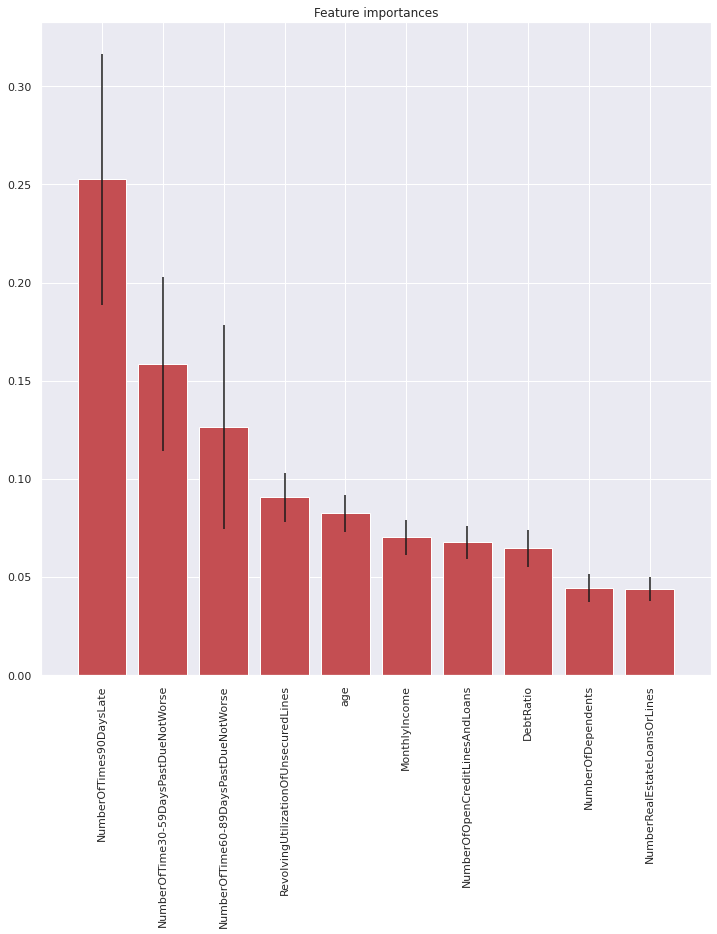

In [ ]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(GMSC_train_X, GMSC_train_y)

feat_names = GMSC_train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

Закончили с датасетом Give Me Some Credit c kaggle

In [ ]:
y = X["Isdefault"]
X = X.drop("Isdefault", axis=1)

In [ ]:
X.head()

,LoanType,Reason,Employment.Length,Employment.Sector,RequestedAmount,OfferedAmount,FundedAmount,Duration,Age,EmailDomain,...,DishounorIn90Days,Income,NonDiscretionarySpending,DiscretionarySpending,RepaymentCapacity,RepaymentFromRequested,ExcessCapacity,RepaymentsRatio,Year,Month
0,New,other,More than 1 year,Customer Service & Call Center,2500.0,2500.0,2500.0,12,21.0,live.com.au,...,0.0,-0.005,1536.0000,500.0000,-2036.0050,161.71,-2197.715,0.0000,2016,11
1,Repeat,other,More than 1 year,Government & Defence,5500.0,3000.0,3000.0,24,26.0,hotmail.com,...,0.0,5316.350,1990.4477,1550.6332,1775.2690,303.80,1471.469,17.1128,2016,11
2,New,other,More than 1 year,"Logistics, Transport & Supply",6300.0,6300.0,6300.0,30,37.0,gmail.com,...,0.0,0.000,0.0000,0.0000,0.0000,0.00,0.000,0.0000,2016,11
4,Repeat,other,3 months to 1 year,Other,4500.0,2500.0,2500.0,13,30.0,outlook.com,...,0.0,238.135,0.0000,209.5370,28.5979,440.92,-412.322,0.0000,2016,11
5,New,other,More than 1 year,NaN,3500.0,3500.0,3500.0,18,49.0,hotmail.com,...,0.0,0.000,0.0000,0.0000,0.0000,0.00,0.000,0.0000,2016,11


In [ ]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#pip install -U KTBoost

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import plot_roc_curve, classification_report, accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import xgboost as xgb
#import KTBoost.KTBoost as KTBoost

In [ ]:
scaler = StandardScaler()
GMSC_train_X.loc[:,:] = scaler.fit_transform(GMSC_train_X)
GMSC_train_X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,-0.019973,-0.435985,0.462455,-0.060775,0.170305,0.819965,-0.061157,4.303154,-0.054477,0.999810
1,-0.019229,-0.782566,-0.109101,-0.062380,-0.282957,-0.919901,-0.061157,-0.917557,-0.054477,0.129023
2,-0.020393,-0.921199,0.176677,-0.062467,-0.252229,-1.306537,0.227422,-0.917557,-0.054477,-0.741765
3,-0.022044,-1.475729,-0.109101,-0.062582,-0.234293,-0.726582,-0.061157,-0.917557,-0.054477,-0.741765
4,-0.019424,-0.158720,0.176677,-0.062609,3.956851,-0.339945,-0.061157,-0.047438,-0.054477,-0.741765


In [ ]:
scaler = StandardScaler()
GMSC_train_X.loc[:,:] = scaler.fit_transform(GMSC_train_X)
X_train, X_test, y_train, y_test = train_test_split(GMSC_train_X, GMSC_train_y, train_size=0.75, random_state=42)
columns = X_test.columns.values
lr = LogisticRegression(C=0.74467)
lr.fit(X_train, y_train)
np.argsort(lr.coef_)
#columns[[8, 4, 1, 6, 2]]
#rf = RandomForestClassifier(n_estimators=100, max_depth=16, min_samples_leaf=1)
#rf.fit(X_train, y_train)
#columns[np.argsort(rf.feature_importances_)[-5:]]
#cat = CatBoostClassifier(iterations=872, learning_rate=0.034313, depth=10)
#cat.fit(X_train, y_train)
#columns[np.argsort(cat.feature_importances_)[-5:]]

array([[8, 4, 1, 3, 5, 0, 7, 9, 6, 2]])

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=66)
numeric_features = X.select_dtypes(include='number').columns
categorical_features = X.select_dtypes(include='object').columns

scaler = StandardScaler()
encoder = LabelEncoder()

X_c = X # для catboost
ohe_cat_df = pd.get_dummies(X[categorical_features])
X.drop(columns=categorical_features, inplace=True)

X[numeric_features] = scaler.fit_transform(X[numeric_features])
X_c[numeric_features] = scaler.fit_transform(X_c[numeric_features])
X = X.join(ohe_cat_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)
X_trainc, X_testc, y_trainc, y_trainc = train_test_split(X_c, y, train_size=0.75, random_state=42)
X_train

,RequestedAmount,OfferedAmount,FundedAmount,Duration,Age,Risk.Rating,Requested.Duration,age.of.file,age.of.subject,time.at.address,...,Product_PL,Employment.Type_Centrelink Only,Employment.Type_Full time,Employment.Type_Other,Employment.Type_Part time,Employment.Type_Self-employed,adverse.on.file_N,adverse.on.file_No,adverse.on.file_Y,adverse.on.file_Yes
8943,-0.993643,-0.708154,-0.707974,-1.478786,-0.366411,-1.195988,-1.664246,-0.720142,1.370031,-0.605726,...,0,0,0,0,1,0,1,0,0,0
9621,-0.060683,0.492545,0.492584,-0.705483,-0.461418,-3.169442,-1.032913,0.125451,1.322179,0.263735,...,0,0,0,0,0,1,1,0,0,0
3801,-0.807051,-0.422273,-0.422127,-0.705483,0.203632,-0.209261,0.229753,-0.913723,-0.463544,-0.605726,...,0,0,1,0,0,0,0,1,0,0
1518,0.685685,1.864773,1.864651,0.841121,0.868681,-1.195988,0.229753,1.709376,-0.421622,0.775937,...,1,0,1,0,0,0,0,1,0,0
5791,-0.060683,-0.422273,-0.422127,-0.705483,2.198780,-0.209261,-1.032913,-0.568450,3.303801,0.181081,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12252,1.805237,0.549721,0.549754,0.841121,-0.461418,-0.209261,0.229753,0.021645,-0.511456,-0.186293,...,0,0,1,0,0,0,0,1,0,0
5292,-0.060683,0.721250,0.721262,-0.705483,-1.126467,-0.209261,-1.032913,-0.781755,0.829948,-0.579080,...,0,0,1,0,0,0,1,0,0,0
5497,-0.620459,-0.136392,-0.136279,0.841121,0.488653,-0.209261,0.229753,0.946847,-0.445577,-0.605726,...,0,0,1,0,0,0,0,1,0,0
882,1.805237,0.721250,0.721262,-0.705483,0.203632,-0.209261,-1.032913,0.997682,-0.463544,-0.433018,...,0,0,0,0,0,1,0,1,0,0


Попробуем сделать для нашего датасета undersampling - сбалансируем классы

In [ ]:
default_index = y[y == 1].index
normal_index = y[y == 0].index

random_normal_index = np.random.choice(normal_index, size=default_index.shape[0], replace=False)

undersample_index = np.concatenate([random_normal_index, default_index.values])
X_undersample_train, X_undersample_test, y_undersample_train, y_undersample_test = train_test_split(X.loc[undersample_index, :],
                                                                                                        y[undersample_index],
                                                                                                   random_state=42,
                                                                                                  train_size=0.75
                                                                                                  )
X_undersample_trainc, X_undersample_testc, y_undersample_trainc, y_undersample_testc = train_test_split(X_c.loc[undersample_index, :],
                                                                                                        y[undersample_index],
                                                                                                   random_state=42,
                                                                                          train_size=0.75                                                                                )

In [ ]:
X_undersample_train

,RequestedAmount,OfferedAmount,FundedAmount,Duration,Age,Risk.Rating,Requested.Duration,age.of.file,age.of.subject,time.at.address,...,Product_PL,Employment.Type_Centrelink Only,Employment.Type_Full time,Employment.Type_Other,Employment.Type_Part time,Employment.Type_Self-employed,adverse.on.file_N,adverse.on.file_No,adverse.on.file_Y,adverse.on.file_Yes
6708,1.805237,1.293011,1.292957,0.067819,0.868681,-2.182715,1.492419,1.658540,-0.421622,-0.284983,...,1,0,1,0,0,0,0,1,0,0
4890,-0.247275,-0.593802,-0.593635,0.841121,1.058695,-0.209261,0.229753,1.587371,-0.409644,-0.433018,...,0,0,1,0,0,0,0,1,0,0
8938,-0.433867,0.149488,0.149568,0.067819,2.673815,-3.169442,-0.401580,1.789492,3.687213,5.931759,...,0,0,0,0,1,0,1,0,0,0
2893,1.058869,-0.136392,-0.136279,0.067819,-1.126467,0.777466,0.229753,-0.974725,-0.547389,-0.433018,...,0,0,1,0,0,0,0,1,0,0
8469,-0.247275,-0.708154,-0.707974,-0.705483,-0.651432,0.777466,0.229753,-0.487520,1.140774,0.749290,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12418,-0.247275,-0.422273,-0.422127,-0.705483,1.533730,0.777466,0.229753,2.474243,2.853971,-0.061943,...,0,0,1,0,0,0,1,0,0,0
1399,0.312501,-0.136392,-0.136279,0.067819,0.963688,0.777466,0.229753,-0.730716,-0.415633,-0.210965,...,0,0,1,0,0,0,0,1,0,0
3901,-0.807051,-0.422273,-0.422127,-0.705483,-0.936453,0.777466,0.229753,-0.527375,-0.535412,-0.482363,...,0,0,1,0,0,0,0,1,0,0
8119,1.805237,-0.708154,-0.707974,-0.705483,-0.366411,-0.209261,-1.032913,-0.151194,-0.505467,-0.210965,...,0,0,1,0,0,0,0,1,0,0


Сделаем для нашего датасета ovesampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_OverSample, y_train_OverSample = ros.fit_resample(X_train, y_train)
X_train_OverSample

,RequestedAmount,OfferedAmount,FundedAmount,Duration,Age,Risk.Rating,Requested.Duration,age.of.file,age.of.subject,time.at.address,...,Product_PL,Employment.Type_Centrelink Only,Employment.Type_Full time,Employment.Type_Other,Employment.Type_Part time,Employment.Type_Self-employed,adverse.on.file_N,adverse.on.file_No,adverse.on.file_Y,adverse.on.file_Yes
0,-0.993643,-0.708154,-0.707974,-1.478786,-0.366411,-1.195988,-1.664246,-0.720142,1.370031,-0.605726,...,0,0,0,0,1,0,1,0,0,0
1,-0.060683,0.492545,0.492584,-0.705483,-0.461418,-3.169442,-1.032913,0.125451,1.322179,0.263735,...,0,0,0,0,0,1,1,0,0,0
2,-0.807051,-0.422273,-0.422127,-0.705483,0.203632,-0.209261,0.229753,-0.913723,-0.463544,-0.605726,...,0,0,1,0,0,0,0,1,0,0
3,0.685685,1.864773,1.864651,0.841121,0.868681,-1.195988,0.229753,1.709376,-0.421622,0.775937,...,1,0,1,0,0,0,0,1,0,0
4,-0.060683,-0.422273,-0.422127,-0.705483,2.198780,-0.209261,-1.032913,-0.568450,3.303801,0.181081,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15663,1.805237,-0.136392,-0.136279,0.067819,-1.031460,0.777466,0.229753,-0.822220,-0.547389,-0.062930,...,0,0,1,0,0,0,0,1,0,0
15664,-0.807051,-0.936858,-0.936652,-0.705483,-0.461418,0.777466,0.229753,-0.883222,-0.505467,-0.581054,...,0,0,1,0,0,0,0,1,0,0
15665,0.312501,1.293011,1.292957,2.387726,-1.126467,-0.209261,1.492419,-0.881697,0.812759,-0.551200,...,1,0,0,0,1,0,1,0,0,0
15666,1.805237,0.721250,0.721262,0.841121,0.868681,-0.209261,0.229753,-0.608712,-0.421622,0.307158,...,0,0,1,0,0,0,0,1,0,0


Сделаем для нащего датасета SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = smt.fit_resample(X_train, y_train)
X_train_SMOTE

,RequestedAmount,OfferedAmount,FundedAmount,Duration,Age,Risk.Rating,Requested.Duration,age.of.file,age.of.subject,time.at.address,...,Product_PL,Employment.Type_Centrelink Only,Employment.Type_Full time,Employment.Type_Other,Employment.Type_Part time,Employment.Type_Self-employed,adverse.on.file_N,adverse.on.file_No,adverse.on.file_Y,adverse.on.file_Yes
0,-0.993643,-0.708154,-0.707974,-1.478786,-0.366411,-1.195988,-1.664246,-0.720142,1.370031,-0.605726,...,0,0,0,0,1,0,1,0,0,0
1,-0.060683,0.492545,0.492584,-0.705483,-0.461418,-3.169442,-1.032913,0.125451,1.322179,0.263735,...,0,0,0,0,0,1,1,0,0,0
2,-0.807051,-0.422273,-0.422127,-0.705483,0.203632,-0.209261,0.229753,-0.913723,-0.463544,-0.605726,...,0,0,1,0,0,0,0,1,0,0
3,0.685685,1.864773,1.864651,0.841121,0.868681,-1.195988,0.229753,1.709376,-0.421622,0.775937,...,1,0,1,0,0,0,0,1,0,0
4,-0.060683,-0.422273,-0.422127,-0.705483,2.198780,-0.209261,-1.032913,-0.568450,3.303801,0.181081,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15663,1.516313,-0.224192,-0.224069,-0.017001,0.309059,0.777466,1.353923,-0.478888,-0.456898,0.164852,...,0,0,1,0,0,0,0,1,0,0
15664,-0.469333,-0.628113,-0.627942,-0.705483,0.398406,0.234778,-1.032913,-0.149853,0.769530,-0.130790,...,0,0,0,0,0,0,0,0,0,0
15665,-0.575630,-0.422273,-0.422127,-0.705483,-0.674257,0.777466,0.229753,-0.320291,-0.518884,-0.575126,...,0,0,1,0,0,0,0,1,0,0
15666,-0.807051,-0.422273,-0.422127,-0.881205,-0.549520,0.777466,-1.176374,-0.227919,-0.511456,-0.411932,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
X_train_SMOTE.sample(10)

,RequestedAmount,OfferedAmount,FundedAmount,Duration,Age,Risk.Rating,Requested.Duration,age.of.file,age.of.subject,time.at.address,...,Product_PL,Employment.Type_Centrelink Only,Employment.Type_Full time,Employment.Type_Other,Employment.Type_Part time,Employment.Type_Self-employed,adverse.on.file_N,adverse.on.file_No,adverse.on.file_Y,adverse.on.file_Yes
8959,-0.807051,-0.422273,-0.422127,-0.963251,-0.746439,-0.209261,-1.243357,-0.252865,-0.523434,-0.605726,...,0,0,1,0,0,0,0,1,0,0
13508,-0.296407,-0.683062,-0.682885,-0.705483,-1.166383,0.690861,0.211282,-0.851900,-0.549906,-0.570226,...,0,0,1,0,0,0,0,1,0,0
11952,-0.911494,-0.582292,-0.582127,-0.365030,0.883612,0.777466,-0.754963,0.472060,-0.420680,2.038884,...,0,0,1,0,0,0,0,1,0,0
6891,-1.142916,-0.936858,-0.936652,-0.705483,0.868681,-0.209261,-1.032913,0.875678,-0.421622,0.479866,...,0,0,1,0,0,0,0,1,0,0
4833,-1.030961,-0.765330,-0.765143,-0.705483,-0.081390,0.777466,-1.032913,0.479163,-0.487500,-0.161620,...,0,0,1,0,0,0,0,1,0,0
13974,-0.743483,-0.324879,-0.324744,0.476940,0.320724,0.023085,-0.067569,0.349792,-0.456163,2.461678,...,0,0,0,0,0,0,0,0,0,1
4059,-0.247275,0.435369,0.435415,0.841121,2.958836,-0.209261,0.229753,1.465366,-0.289865,1.565458,...,0,0,1,0,0,0,0,1,0,0
698,-0.209956,-0.708154,-0.707974,-1.092135,-1.316481,0.777466,-0.717247,-1.045691,0.638661,-0.605233,...,0,0,1,0,0,0,1,0,0,0
6782,0.312501,1.293011,1.292957,2.387726,0.108624,-1.195988,1.492419,0.682504,-0.469533,0.035760,...,1,0,1,0,0,0,0,1,0,0
13318,-0.226753,0.372486,0.372539,0.067819,-1.137882,0.777466,0.229753,-0.878749,-0.548109,-0.216392,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
# класс-пайплайн для тестирования и подбора гиперпараметров
import optuna
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import fbeta_score, precision_score, recall_score, roc_curve, precision_recall_curve, average_precision_score

class ModelPreparation :
    def __init__(self, data, target, estimator, is_balanced=False, verbose=False):
        self.data = data
        self.target = target
        self.verbose = verbose
        self.estimator = estimator
        self.best_params = None
        self.is_balanced = is_balanced

    def objective(self, trial):
        # переберем параметры
        print('kek')
        if self.verbose:
            print(self.parameters.keys())
        if self.estimator is LogisticRegression:
            _C = trial.suggest_float("C" , 0.001, 1)
            new_estimator = LogisticRegression(C=_C)
        elif self.estimator is RandomForestClassifier:
            _n_estimators = trial.suggest_int("n_estimators", 100, 501, step=100) #: np.arange(100, 1001, 100),
            _max_depth = trial.suggest_int("max_depth", 4, 17, step=4) #: np.arange(4, 17, 4),
            _min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50, step=10) #: np.arange(1, 100, 10)
            new_estimator = RandomForestClassifier(n_estimators = _n_estimators, max_depth = _max_depth, min_samples_leaf = _min_samples_leaf)
        elif self.estimator is xgb.XGBClassifier:
            _eta = trial.suggest_float("eta", -2, 1, log=10) #: np.linspace(0.01, 10, 20)
            _max_depth = trial.suggest_int("max_depth", 2, 16) #: np.arange(2, 16),
            _alpha = trial.suggest_float("alpha", 0.001, 1.0) #: np.arange(0.001, 1, 0.005)
            new_estimator = xgb.XGBClassifier(eta = _eta, max_depth = _max_depth, alpha = _alpha)
        elif self.estimator is CatBoostClassifier:
            _iterations = trial.suggest_int("iterations", 100, 1000) #: np.arange(100, 300, 100),
            _learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0) #: np.arange(0.001, 1, 0.075),
            _depth = trial.suggest_int("depth", 2, 16) #: np.arange(2, 8),
            new_estimator = CatBoostClassifier(iterations = _iterations, learning_rate = _learning_rate, depth = _depth, verbose = False)
        elif self.estimator is LGBMClassifier:
            _num_iterations = trial.suggest_int("num_iterations", 100, 1001) #: np.arange(100, 1500, 100),
            _learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0) #: np.arange(0.001, 1, 0.005),
            _max_depth = trial.suggest_int("max_depth", 2, 16) # : np.arange(2, 16),
            new_estimator = LGBMClassifier(num_iterations = _num_iterations, learning_rate = _learning_rate, max_depth = _max_depth)
        elif self.estimator is GradientBoostingClassifier:
            _learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, step=0.005) #: np.arange(0.001, 1, 0.005),
            _max_depth = trial.suggest_int("max_depth", 2, 16, step=2) # : np.arange(2, 16),
            new_estimator = GradientBoostingClassifier(learning_rate = _learning_rate, max_depth = _max_depth)
        else:
            print('lol')

        if self.is_balanced:
            scorer="accuracy"
        else:
            scorer = "f1_weighted"
        scores = cross_val_score(new_estimator, self.data, self.target,
                                 cv=KFold(n_splits=10, shuffle=True, random_state=42), scoring=scorer)

        return scores.mean()

    def tune_params(self):
      study = optuna.create_study(direction="maximize")
      study.optimize(self.objective, n_trials=100, n_jobs=-1) # Use more
      self.best_params = study.best_params
      best_score = study.best_value
      print(f"Best score: {best_score}\n")


    def classification_report(self, test_data, test_target, is_balanced=True):
        model = self.estimator() #**self.best_params
        model.fit(self.data, self.target)
        y_pred = model.predict(test_data)

        print("Classification report for {}:".format(self.estimator.__name__))
        print("F0.5 score = {:.4f}".format(fbeta_score(test_target, y_pred, beta=0.5)))
        print("F1 score = {:.4f}".format(fbeta_score(test_target, y_pred, beta=1)))
        print("F2 score = {:.4f}".format(fbeta_score(test_target, y_pred, beta=2)))
        print("recall score = {:.4f}".format(recall_score(test_target, y_pred)))
        print("precision score = {:.4f}".format(precision_score(test_target, y_pred)))
        if self.is_balanced:
            print("Accuracy on balanced class data = {:.4f}".format(accuracy_score(test_target, y_pred)))
        fig, axes = plt.subplots(figsize=(16, 10), ncols=2, nrows=1)

        ns_probs = [0 for _ in range(test_target.shape[0])]
        probs = model.predict_proba(test_data)
        probs = probs[:, 1]
        ns_auc = roc_auc_score(test_target, ns_probs)
        model_auc = roc_auc_score(test_target, probs)

        ns_fpr, ns_tpr, _ = roc_curve(test_target, ns_probs)
        fpr, tpr, _ = roc_curve(test_target, probs)

        axes[0].set(title="ROC curve with ROC AUC = {:.4f}".format(roc_auc_score(test_target, probs)))
        axes[0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        axes[0].plot(fpr, tpr, marker='.', label=self.estimator.__name__)

        #axes[0].xlabel('False Positive Rate')
        #axes[0].ylabel('True Positive Rate')

        probs = model.predict_proba(test_data)
        probs = probs[:, 1]
        no_skill = len(test_target[test_target == 1]) / len(test_target)

        axes[1].plot([no_skill, no_skill], linestyle='--', label='No Skill')
        precision, recall, _ = precision_recall_curve(test_target, probs)

        axes[1].plot(recall, precision, marker='.', label=self.estimator.__name__)
        #axes[1].xlabel('Recall')
        #axes[1].ylabel('Precision')


        axes[1].set(title="PR curve with PR AUC = {:.4f}".format(average_precision_score(test_target, probs)))
        axes[0].legend()
        axes[1].legend()

        plt.show()




In [ ]:
test_lr = ModelPreparation(X_train_OverSample, y_train_OverSample, LogisticRegression)
test_lr.classification_report(X_test, y_test, True)

NameError: ignored

Classification report for LogisticRegression:
F0.5 score = 0.2215
F1 score = 0.1212
F2 score = 0.0834
recall score = 0.0691
precision score = 0.4938


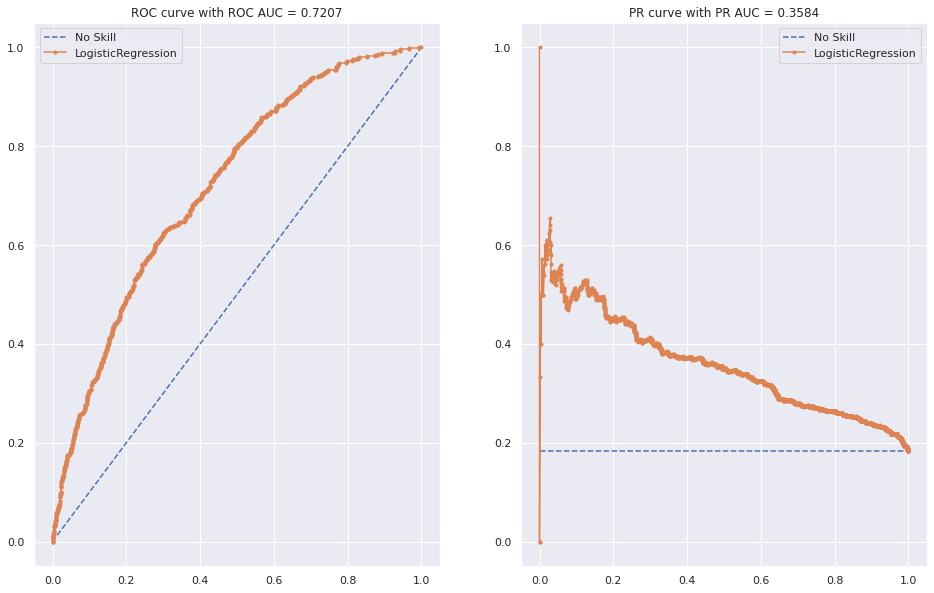

In [ ]:
test_lr = ModelPreparation(X_train_SMOTE, y_train_SMOTE, LogisticRegression)
test_lr.classification_report(X_test, y_test, True)

In [ ]:
y_pred_oversample = lr_oversample.predict(X_oversample_test)
print(classification_report(y_oversample_test, y_pred_oversample))


NameError: ignored

In [ ]:
test_lr = ModelPreparation(X_undersample_train, y_undersample_train, LogisticRegression)
test_lr.tune_params()

[I 2021-12-13 21:49:15,157] A new study created in memory with name: no-name-e12b1b40-4da9-4fbd-a4cf-afbb61aeffe7
[I 2021-12-13 21:49:21,391] Trial 1 finished with value: 0.6391691394658754 and parameters: {'num_iterations': 800, 'learning_rate': 0.261, 'max_depth': 12}. Best is trial 1 with value: 0.6391691394658754.
[I 2021-12-13 21:49:28,470] Trial 1 finished with value: 0.6253916540738518 and parameters: {'C': 0.8219929687695392}. Best is trial 1 with value: 0.6253916540738518.
[I 2021-12-13 21:49:28,853] Trial 0 finished with value: 0.6274735587880131 and parameters: {'C': 0.32164368580944264}. Best is trial 0 with value: 0.6274735587880131.
[I 2021-12-13 21:49:39,679] Trial 2 finished with value: 0.6265530182074388 and parameters: {'C': 0.4736495336588032}. Best is trial 0 with value: 0.6274735587880131.
[I 2021-12-13 21:49:40,093] Trial 3 finished with value: 0.6306214464078049 and parameters: {'C': 0.14785333008870774}. Best is trial 3 with value: 0.6306214464078049.
[I 2021-12

Best score: 0.6389913007262727



Classification report for LogisticRegression:
F0.5 score = 0.6242
F1 score = 0.6522
F2 score = 0.6828
recall score = 0.7049
precision score = 0.6068


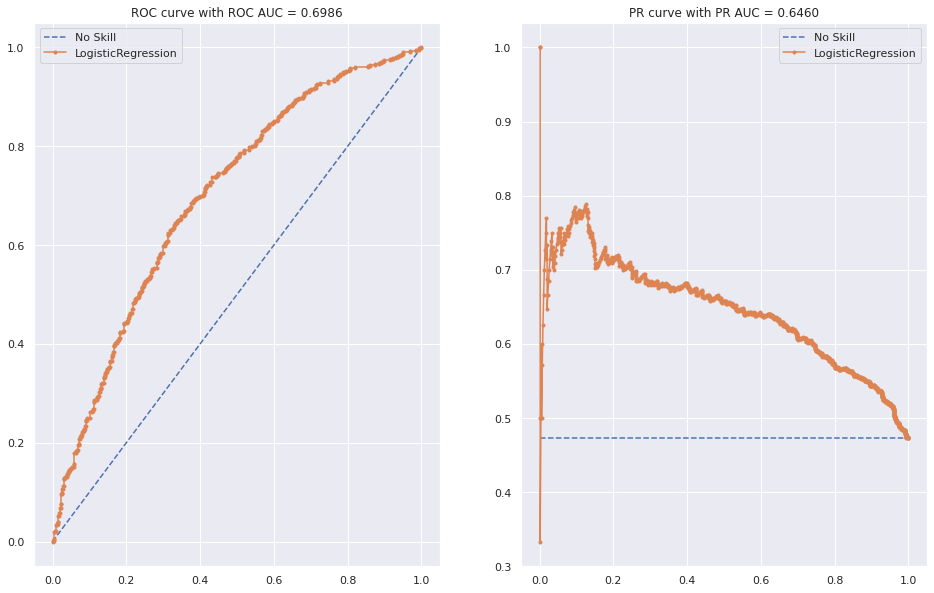

In [ ]:
test_lr.classification_report(X_undersample_test, y_undersample_test, True)

In [ ]:
y_pred_undersample = lr_undersample.predict(X_undersample_test)
print(classification_report(y_undersample_test, y_pred_undersample))

              precision    recall  f1-score   support

         0.0       0.69      0.56      0.61       592
         1.0       0.59      0.72      0.65       532

    accuracy                           0.63      1124
   macro avg       0.64      0.64      0.63      1124
weighted avg       0.64      0.63      0.63      1124



'LogisticRegression'

In [ ]:
y_pred_common = lr_undersample.predict(X_test)
print(classification_report(y_test, y_pred_common))

              precision    recall  f1-score   support

         0.0       0.91      0.59      0.71      2589
         1.0       0.29      0.74      0.41       579

    accuracy                           0.61      3168
   macro avg       0.60      0.66      0.56      3168
weighted avg       0.80      0.61      0.66      3168



In [ ]:
test_lr_undersample = ModelPreparation(X_undersample_train, y_undersample_train)
test_lr_undersample.define_model(LogisticRegression)
lr_params_undersample = test_lr_undersample.hyperparameters_tuning()
auc_lr_undersample, f05_lr_undersample = test_lr_undersample.apply_best_params(lr_params_undersample,
                                                                               X_undersample_test,
                                                                               y_undersample_test)
print(lr_params_undersample.items())
print("AUC ROC score on LR with undersampling: {:.4f}".format(auc_lr_undersample))
print("F0.5 score on LR with undersampling: {:.4f}".format(f05_lr_undersample))

dict_items([('C', 0.008497534359086447)])
AUC ROC score on LR with undersampling: 0.6329
F0.5 score on LR with undersampling: 0.6104


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.686


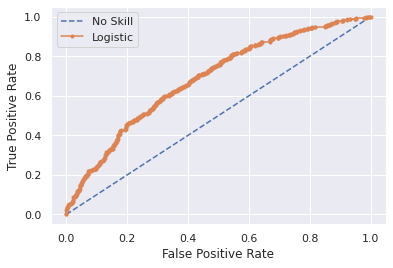

In [ ]:
from sklearn.metrics import roc_curve

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(y_undersample_test.shape[0])]
# predict probabilities
model_lr = LogisticRegression().set_params(**lr_params_undersample).fit(X_undersample_train, y_undersample_train)
lr_probs = model_lr.predict_proba(X_undersample_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_undersample_test, ns_probs)
lr_auc = roc_auc_score(y_undersample_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_undersample_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_undersample_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
test_rf = ModelPreparation(X_train, y_train)
test_rf.define_model(RandomForestClassifier)
rf_params = test_rf.hyperparameters_tuning()
auc_rf, f05_rf = test_rf.apply_best_params(rf_params, X_test, y_test)
print("AUC ROC score on RF:", auc_rf)
print("F0.5 score on RF:", f05_rf)

AUC ROC score on RF: 0.5003398896751546
F0.5 score on RF: 0.008865248226950354


In [ ]:
test_rf_undersample = ModelPreparation(X_undersample_train, y_undersample_train)
test_rf_undersample.define_model(RandomForestClassifier)
rf_params_undersample = test_rf_undersample.hyperparameters_tuning()
auc_rf_undersample, f05_rf_undersample = test_rf_undersample.apply_best_params(rf_params_undersample,
                                                                               X_undersample_test,
                                                                               y_undersample_test)
print("AUC ROC score on RF with undersampling: {:.4f}".format(auc_rf_undersample))
print("F0.5 score on RF with undersampling: {:.4f}".format(f05_rf_undersample))

AUC ROC score on RF with undersampling: 0.6202
F0.5 score on RF with undersampling: 0.5988


In [ ]:
auc_rf_undersample_train, f05_rf_undersample_train = test_rf_undersample.apply_best_params(rf_params_undersample,
                                                                               X_undersample_train,
                                                                               y_undersample_train)
print("AUC ROC score on RF with undersampling: {:.4f}".format(auc_rf_undersample_train))
print("F0.5 score on RF with undersampling: {:.4f}".format(f05_rf_undersample_train))

AUC ROC score on RF with undersampling: 0.7884
F0.5 score on RF with undersampling: 0.7809


In [ ]:
model = RandomForestClassifier().set_params(**rf_params).fit(X_undersample_train, y_undersample_train)
y_pred = model.predict(X_undersample_test)
print(classification_report(y_pred, y_undersample_test))

              precision    recall  f1-score   support

         0.0       0.57      0.66      0.61       508
         1.0       0.67      0.58      0.63       616

    accuracy                           0.62      1124
   macro avg       0.62      0.62      0.62      1124
weighted avg       0.63      0.62      0.62      1124



In [ ]:
test = ModelPreparation(X_train, y_train)
test.define_model(RandomForestClassifier)
rf_params = test.hyperparameters_tuning()
model = RandomForestClassifier().set_params(**rf_params).fit(X_undersample_train, y_undersample_train)
y_pred = model.predict(X_undersample_test)
print(classification_report(y_pred, y_undersample_test))

              precision    recall  f1-score   support

         0.0       0.57      0.66      0.61       510
         1.0       0.67      0.58      0.62       614

    accuracy                           0.62      1124
   macro avg       0.62      0.62      0.62      1124
weighted avg       0.62      0.62      0.62      1124



In [ ]:
test_catboost_undersample = ModelPreparation(X_undersample_train, y_undersample_train)
test_catboost_undersample.define_model(CatBoostClassifier)
catboost_params_undersample = test_catboost_undersample.hyperparameters_tuning()
auc_catboost_undersample, f05_catboost_undersample = test_catboost_undersample.apply_best_params(catboost_params_undersample,
                                                                               X_undersample_test,
                                                                               y_undersample_test)
print(catboost_params_undersample.items())
print("AUC ROC score on RF with undersampling: {:.4f}".format(auc_catboost_undersample))
print("F0.5 score on RF with undersampling: {:.4f}".format(f05_catboost_undersample))

Выходные данные были обрезаны до нескольких последних строк (5000).
3:	learn: 0.5508676	total: 147ms	remaining: 7.19s
4:	learn: 0.5257126	total: 177ms	remaining: 6.9s
5:	learn: 0.5116343	total: 208ms	remaining: 6.71s
6:	learn: 0.4944823	total: 244ms	remaining: 6.72s
7:	learn: 0.4861112	total: 274ms	remaining: 6.58s
8:	learn: 0.4679803	total: 320ms	remaining: 6.78s
9:	learn: 0.4609410	total: 352ms	remaining: 6.68s
10:	learn: 0.4377287	total: 383ms	remaining: 6.59s
11:	learn: 0.4255470	total: 415ms	remaining: 6.51s
12:	learn: 0.4102838	total: 447ms	remaining: 6.43s
13:	learn: 0.3935510	total: 479ms	remaining: 6.37s
14:	learn: 0.3752031	total: 511ms	remaining: 6.3s
15:	learn: 0.3561903	total: 557ms	remaining: 6.4s
16:	learn: 0.3435778	total: 589ms	remaining: 6.33s
17:	learn: 0.3283198	total: 619ms	remaining: 6.26s
18:	learn: 0.3124947	total: 649ms	remaining: 6.18s
19:	learn: 0.3025465	total: 680ms	remaining: 6.12s
20:	learn: 0.2885767	total: 710ms	remaining: 6.05s
21:	learn: 0.2837101	tot

In [ ]:
test_xgb = ModelPreparation(X_train, y_train, LGBMClassifier)
test_xgb.tune_params()

[I 2021-12-16 21:47:10,239] A new study created in memory with name: no-name-9863f7b7-3019-4af5-b824-b82aba665ced


kek
kek


[I 2021-12-16 21:48:08,307] Trial 0 finished with value: 0.7705383365025497 and parameters: {'num_iterations': 138, 'learning_rate': 0.3486816485514269, 'max_depth': 5}. Best is trial 0 with value: 0.7705383365025497.
[I 2021-12-16 21:48:38,531] Trial 1 finished with value: 0.7538941108568862 and parameters: {'num_iterations': 135, 'learning_rate': 0.9856015896669778, 'max_depth': 13}. Best is trial 0 with value: 0.7705383365025497.
[I 2021-12-16 21:48:39,702] Trial 5 finished with value: 0.7738375707152834 and parameters: {'num_iterations': 655, 'learning_rate': 0.6875558467415114, 'max_depth': 9}. Best is trial 5 with value: 0.7738375707152834.
[I 2021-12-16 21:49:04,725] Trial 4 finished with value: 0.7665918724187089 and parameters: {'num_iterations': 713, 'learning_rate': 0.09559977875022325, 'max_depth': 12}. Best is trial 5 with value: 0.7738375707152834.
[I 2021-12-16 21:49:24,776] Trial 0 finished with value: 0.73449534559289 and parameters: {'num_iterations': 661, 'learning_r

kek


[I 2021-12-16 21:49:43,639] Trial 1 finished with value: 0.7720951332135365 and parameters: {'num_iterations': 527, 'learning_rate': 0.7759978264813634, 'max_depth': 9}. Best is trial 1 with value: 0.7720951332135365.


kek


[I 2021-12-16 21:50:21,847] Trial 2 finished with value: 0.7707142296580972 and parameters: {'num_iterations': 419, 'learning_rate': 0.8762302795159101, 'max_depth': 5}. Best is trial 1 with value: 0.7720951332135365.


kek


[I 2021-12-16 21:51:25,142] Trial 4 finished with value: 0.7401533194280564 and parameters: {'num_iterations': 417, 'learning_rate': 0.9406964048338669, 'max_depth': 11}. Best is trial 1 with value: 0.7720951332135365.


kek


[I 2021-12-16 21:52:44,093] Trial 3 finished with value: 0.7676419681500706 and parameters: {'num_iterations': 762, 'learning_rate': 0.009869766151020642, 'max_depth': 12}. Best is trial 1 with value: 0.7720951332135365.


kek


[I 2021-12-16 21:53:04,304] Trial 5 finished with value: 0.76918191358353 and parameters: {'num_iterations': 490, 'learning_rate': 0.1519923721158344, 'max_depth': 8}. Best is trial 1 with value: 0.7720951332135365.


kek


[I 2021-12-16 21:55:20,777] Trial 7 finished with value: 0.7714240335447737 and parameters: {'num_iterations': 693, 'learning_rate': 0.3846742460357701, 'max_depth': 10}. Best is trial 1 with value: 0.7720951332135365.


kek


[I 2021-12-16 21:55:50,201] Trial 6 finished with value: 0.7685161518561135 and parameters: {'num_iterations': 858, 'learning_rate': 0.1987340581334533, 'max_depth': 14}. Best is trial 1 with value: 0.7720951332135365.


kek


[I 2021-12-16 21:57:16,399] Trial 9 finished with value: 0.7698133465020992 and parameters: {'num_iterations': 447, 'learning_rate': 0.6495106354292106, 'max_depth': 9}. Best is trial 1 with value: 0.7720951332135365.


kek


[I 2021-12-16 21:57:25,859] Trial 8 finished with value: 0.7723784959755744 and parameters: {'num_iterations': 740, 'learning_rate': 0.48425681243486585, 'max_depth': 9}. Best is trial 8 with value: 0.7723784959755744.


kek


[I 2021-12-16 21:57:42,065] Trial 11 finished with value: 0.7689868678828761 and parameters: {'num_iterations': 215, 'learning_rate': 0.4991798245519176, 'max_depth': 3}. Best is trial 8 with value: 0.7723784959755744.


kek


[I 2021-12-16 21:58:40,167] Trial 10 finished with value: 0.7691731398207723 and parameters: {'num_iterations': 433, 'learning_rate': 0.6892105548905392, 'max_depth': 10}. Best is trial 8 with value: 0.7723784959755744.


kek


[I 2021-12-16 21:59:35,798] Trial 12 finished with value: 0.7712776709362229 and parameters: {'num_iterations': 898, 'learning_rate': 0.7123649614924552, 'max_depth': 7}. Best is trial 8 with value: 0.7723784959755744.


kek


[I 2021-12-16 22:00:28,771] Trial 13 finished with value: 0.772795911166349 and parameters: {'num_iterations': 881, 'learning_rate': 0.7221892582583844, 'max_depth': 6}. Best is trial 13 with value: 0.772795911166349.


kek


[I 2021-12-16 22:00:58,143] Trial 14 finished with value: 0.77039216290261 and parameters: {'num_iterations': 581, 'learning_rate': 0.44443485599578714, 'max_depth': 5}. Best is trial 13 with value: 0.772795911166349.


kek


[I 2021-12-16 22:02:41,846] Trial 15 finished with value: 0.7724731703491717 and parameters: {'num_iterations': 992, 'learning_rate': 0.5052264362855684, 'max_depth': 6}. Best is trial 13 with value: 0.772795911166349.


kek


[I 2021-12-16 22:02:58,237] Trial 16 finished with value: 0.7718497065132504 and parameters: {'num_iterations': 929, 'learning_rate': 0.5894785944305908, 'max_depth': 6}. Best is trial 13 with value: 0.772795911166349.


kek


[I 2021-12-16 22:03:31,408] Trial 17 finished with value: 0.76591299707365 and parameters: {'num_iterations': 995, 'learning_rate': 0.5967287701249995, 'max_depth': 2}. Best is trial 13 with value: 0.772795911166349.


kek


[I 2021-12-16 22:04:04,991] Trial 18 finished with value: 0.7755199664427369 and parameters: {'num_iterations': 973, 'learning_rate': 0.3264586134738595, 'max_depth': 3}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:05:00,388] Trial 20 finished with value: 0.7746425256129826 and parameters: {'num_iterations': 805, 'learning_rate': 0.31573797446729984, 'max_depth': 3}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:05:08,697] Trial 19 finished with value: 0.7744075297099775 and parameters: {'num_iterations': 1001, 'learning_rate': 0.29092973716364023, 'max_depth': 4}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:05:56,594] Trial 21 finished with value: 0.7752026354825463 and parameters: {'num_iterations': 811, 'learning_rate': 0.28512909576137846, 'max_depth': 3}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:06:04,405] Trial 22 finished with value: 0.7752936671915321 and parameters: {'num_iterations': 805, 'learning_rate': 0.28744333289481905, 'max_depth': 3}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:06:35,776] Trial 24 finished with value: 0.7744886945411098 and parameters: {'num_iterations': 615, 'learning_rate': 0.14216653163003867, 'max_depth': 2}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:06:37,923] Trial 23 finished with value: 0.7748594719156631 and parameters: {'num_iterations': 815, 'learning_rate': 0.33191528812317694, 'max_depth': 2}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:06:50,060] Trial 26 finished with value: 0.7712729517901675 and parameters: {'num_iterations': 106, 'learning_rate': 0.23604767673201385, 'max_depth': 4}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:07:51,750] Trial 25 finished with value: 0.7721613631328259 and parameters: {'num_iterations': 784, 'learning_rate': 0.25615752685846377, 'max_depth': 4}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:08:00,661] Trial 27 finished with value: 0.7687781616100443 and parameters: {'num_iterations': 723, 'learning_rate': 0.025459313344335766, 'max_depth': 4}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:08:47,937] Trial 29 finished with value: 0.7743142307915111 and parameters: {'num_iterations': 944, 'learning_rate': 0.37713428647197417, 'max_depth': 2}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:08:55,132] Trial 28 finished with value: 0.772453031464494 and parameters: {'num_iterations': 931, 'learning_rate': 0.07574701427508923, 'max_depth': 3}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:11:04,481] Trial 30 finished with value: 0.7726354935979131 and parameters: {'num_iterations': 627, 'learning_rate': 0.10878740293787609, 'max_depth': 15}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:11:08,866] Trial 31 finished with value: 0.7710760605566581 and parameters: {'num_iterations': 645, 'learning_rate': 0.3896625799908464, 'max_depth': 16}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:11:46,688] Trial 32 finished with value: 0.7727374952080104 and parameters: {'num_iterations': 830, 'learning_rate': 0.35523529003925897, 'max_depth': 2}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:11:51,567] Trial 33 finished with value: 0.7745068406645809 and parameters: {'num_iterations': 843, 'learning_rate': 0.33596530243027467, 'max_depth': 2}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:13:25,712] Trial 35 finished with value: 0.7696623296487572 and parameters: {'num_iterations': 685, 'learning_rate': 0.2094854994488971, 'max_depth': 5}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:13:41,059] Trial 34 finished with value: 0.7739012566973587 and parameters: {'num_iterations': 838, 'learning_rate': 0.19301046261635324, 'max_depth': 5}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:14:19,167] Trial 36 finished with value: 0.7743539653549194 and parameters: {'num_iterations': 771, 'learning_rate': 0.27951460439115416, 'max_depth': 3}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:14:34,208] Trial 37 finished with value: 0.7691705055207563 and parameters: {'num_iterations': 760, 'learning_rate': 0.43397758720990653, 'max_depth': 3}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:15:33,315] Trial 38 finished with value: 0.770007182225982 and parameters: {'num_iterations': 360, 'learning_rate': 0.43544171673191445, 'max_depth': 7}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:17:03,541] Trial 39 finished with value: 0.7715643741819729 and parameters: {'num_iterations': 890, 'learning_rate': 0.4329170030342252, 'max_depth': 12}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:17:19,146] Trial 40 finished with value: 0.773402027836651 and parameters: {'num_iterations': 896, 'learning_rate': 0.8595497179991975, 'max_depth': 13}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:17:57,511] Trial 41 finished with value: 0.7685128690252516 and parameters: {'num_iterations': 510, 'learning_rate': 0.8535862175445534, 'max_depth': 4}. Best is trial 18 with value: 0.7755199664427369.


kek


[I 2021-12-16 22:18:16,039] Trial 42 finished with value: 0.7766053705517113 and parameters: {'num_iterations': 814, 'learning_rate': 0.31729427565583945, 'max_depth': 3}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:18:53,622] Trial 43 finished with value: 0.775482764584815 and parameters: {'num_iterations': 800, 'learning_rate': 0.3312060996511332, 'max_depth': 3}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:19:05,454] Trial 44 finished with value: 0.7752903024183102 and parameters: {'num_iterations': 716, 'learning_rate': 0.16254467545938633, 'max_depth': 3}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:19:43,606] Trial 45 finished with value: 0.7755958638551483 and parameters: {'num_iterations': 725, 'learning_rate': 0.17122997609512064, 'max_depth': 3}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:21:25,533] Trial 46 finished with value: 0.7658908585067848 and parameters: {'num_iterations': 721, 'learning_rate': 0.15136689627168, 'max_depth': 7}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:22:00,651] Trial 47 finished with value: 0.7704493930048135 and parameters: {'num_iterations': 684, 'learning_rate': 0.07290358379628765, 'max_depth': 8}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:22:57,552] Trial 48 finished with value: 0.7723960370919628 and parameters: {'num_iterations': 674, 'learning_rate': 0.2355501201361163, 'max_depth': 5}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:23:55,726] Trial 50 finished with value: 0.7711314660418219 and parameters: {'num_iterations': 583, 'learning_rate': 0.565821251398025, 'max_depth': 4}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:24:09,868] Trial 49 finished with value: 0.774060213654994 and parameters: {'num_iterations': 947, 'learning_rate': 0.23322274401227472, 'max_depth': 5}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:25:01,147] Trial 52 finished with value: 0.7760136602950831 and parameters: {'num_iterations': 748, 'learning_rate': 0.18451339232578023, 'max_depth': 3}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:26:19,686] Trial 51 finished with value: 0.7690101682206243 and parameters: {'num_iterations': 962, 'learning_rate': 0.4021589382217704, 'max_depth': 6}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:26:24,580] Trial 53 finished with value: 0.773368290916838 and parameters: {'num_iterations': 866, 'learning_rate': 0.20094693918944462, 'max_depth': 4}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:27:16,708] Trial 55 finished with value: 0.7738706548491094 and parameters: {'num_iterations': 750, 'learning_rate': 0.3077645204047852, 'max_depth': 3}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:27:19,584] Trial 54 finished with value: 0.7763315314196196 and parameters: {'num_iterations': 875, 'learning_rate': 0.18845903885755347, 'max_depth': 3}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:27:56,229] Trial 56 finished with value: 0.7708091272370658 and parameters: {'num_iterations': 782, 'learning_rate': 0.09510985776694608, 'max_depth': 2}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:28:02,986] Trial 57 finished with value: 0.7734721839690938 and parameters: {'num_iterations': 865, 'learning_rate': 0.10680992020681543, 'max_depth': 2}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:29:43,854] Trial 58 finished with value: 0.7537710537935522 and parameters: {'num_iterations': 910, 'learning_rate': 0.0037667915008052777, 'max_depth': 4}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:30:49,322] Trial 60 finished with value: 0.7683839717839802 and parameters: {'num_iterations': 353, 'learning_rate': 0.5259122425564129, 'max_depth': 6}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:31:18,510] Trial 59 finished with value: 0.767840961134982 and parameters: {'num_iterations': 912, 'learning_rate': 0.023896570988440946, 'max_depth': 10}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:32:13,636] Trial 62 finished with value: 0.7711465207758199 and parameters: {'num_iterations': 812, 'learning_rate': 0.2665550663713348, 'max_depth': 3}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:33:07,472] Trial 63 finished with value: 0.7750946148581022 and parameters: {'num_iterations': 795, 'learning_rate': 0.1661159232037698, 'max_depth': 3}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:34:15,098] Trial 61 finished with value: 0.7680657435115921 and parameters: {'num_iterations': 972, 'learning_rate': 0.1753642370481391, 'max_depth': 10}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:35:05,898] Trial 64 finished with value: 0.7720413790103402 and parameters: {'num_iterations': 867, 'learning_rate': 0.35498404821638796, 'max_depth': 5}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:35:27,669] Trial 65 finished with value: 0.7736064395981399 and parameters: {'num_iterations': 740, 'learning_rate': 0.36069753598491405, 'max_depth': 4}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:36:09,462] Trial 67 finished with value: 0.7734422995621837 and parameters: {'num_iterations': 842, 'learning_rate': 0.13158706920095314, 'max_depth': 2}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:36:16,563] Trial 66 finished with value: 0.7728536421683521 and parameters: {'num_iterations': 718, 'learning_rate': 0.25228182310657127, 'max_depth': 4}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:37:01,011] Trial 68 finished with value: 0.7631445972331484 and parameters: {'num_iterations': 714, 'learning_rate': 0.9901859157469141, 'max_depth': 3}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:37:11,391] Trial 69 finished with value: 0.7752278916569125 and parameters: {'num_iterations': 788, 'learning_rate': 0.31653903916815873, 'max_depth': 3}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:37:40,730] Trial 70 finished with value: 0.7747564660573032 and parameters: {'num_iterations': 780, 'learning_rate': 0.30389187353160313, 'max_depth': 2}. Best is trial 42 with value: 0.7766053705517113.


kek


[I 2021-12-16 22:37:57,944] Trial 71 finished with value: 0.7769524509627925 and parameters: {'num_iterations': 922, 'learning_rate': 0.21862007725835592, 'max_depth': 2}. Best is trial 71 with value: 0.7769524509627925.


kek


[I 2021-12-16 22:38:33,006] Trial 72 finished with value: 0.7717884073589973 and parameters: {'num_iterations': 751, 'learning_rate': 0.2234457613461532, 'max_depth': 3}. Best is trial 71 with value: 0.7769524509627925.


kek


[I 2021-12-16 22:38:46,778] Trial 73 finished with value: 0.7750897837030494 and parameters: {'num_iterations': 973, 'learning_rate': 0.21017813556613246, 'max_depth': 2}. Best is trial 71 with value: 0.7769524509627925.


kek


[I 2021-12-16 22:39:20,016] Trial 74 finished with value: 0.7711880326020337 and parameters: {'num_iterations': 926, 'learning_rate': 0.2718435698473621, 'max_depth': 2}. Best is trial 71 with value: 0.7769524509627925.


kek


[I 2021-12-16 22:39:28,767] Trial 75 finished with value: 0.7744209332265863 and parameters: {'num_iterations': 828, 'learning_rate': 0.26910147212401514, 'max_depth': 2}. Best is trial 71 with value: 0.7769524509627925.


kek


[I 2021-12-16 22:40:39,411] Trial 76 finished with value: 0.773061411150474 and parameters: {'num_iterations': 838, 'learning_rate': 0.058547429779840066, 'max_depth': 4}. Best is trial 71 with value: 0.7769524509627925.


kek


[I 2021-12-16 22:40:52,758] Trial 77 finished with value: 0.7744761697395465 and parameters: {'num_iterations': 881, 'learning_rate': 0.12835685184226844, 'max_depth': 4}. Best is trial 71 with value: 0.7769524509627925.


kek


[I 2021-12-16 22:41:38,356] Trial 79 finished with value: 0.7776901535795898 and parameters: {'num_iterations': 652, 'learning_rate': 0.331676209828838, 'max_depth': 3}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:41:41,021] Trial 78 finished with value: 0.7692381132250897 and parameters: {'num_iterations': 885, 'learning_rate': 0.465883170301471, 'max_depth': 3}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:42:23,162] Trial 80 finished with value: 0.7740740904098695 and parameters: {'num_iterations': 656, 'learning_rate': 0.17901764916663093, 'max_depth': 3}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:43:07,510] Trial 82 finished with value: 0.7689409290741265 and parameters: {'num_iterations': 640, 'learning_rate': 0.3454527686143692, 'max_depth': 3}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:43:10,015] Trial 81 finished with value: 0.7680392825077543 and parameters: {'num_iterations': 652, 'learning_rate': 0.184304746009266, 'max_depth': 5}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:43:40,088] Trial 84 finished with value: 0.7733883492365776 and parameters: {'num_iterations': 580, 'learning_rate': 0.40596181943663445, 'max_depth': 2}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:43:48,354] Trial 83 finished with value: 0.7716981243562 and parameters: {'num_iterations': 804, 'learning_rate': 0.41386489597582754, 'max_depth': 2}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:44:48,617] Trial 85 finished with value: 0.7746998269270277 and parameters: {'num_iterations': 694, 'learning_rate': 0.29774636372446084, 'max_depth': 4}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:44:56,760] Trial 86 finished with value: 0.7697759628377078 and parameters: {'num_iterations': 692, 'learning_rate': 0.3261017689553313, 'max_depth': 4}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:45:57,707] Trial 87 finished with value: 0.773264332749491 and parameters: {'num_iterations': 999, 'learning_rate': 0.3758028222983537, 'max_depth': 3}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:46:02,133] Trial 88 finished with value: 0.7745655280819107 and parameters: {'num_iterations': 945, 'learning_rate': 0.3669300186727157, 'max_depth': 3}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:47:02,190] Trial 89 finished with value: 0.7744263627010276 and parameters: {'num_iterations': 949, 'learning_rate': 0.24447154314447245, 'max_depth': 3}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:47:26,730] Trial 90 finished with value: 0.7730129472732301 and parameters: {'num_iterations': 616, 'learning_rate': 0.24786624220062065, 'max_depth': 5}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:48:03,404] Trial 92 finished with value: 0.7738708899915583 and parameters: {'num_iterations': 738, 'learning_rate': 0.1554405866728828, 'max_depth': 2}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:48:25,357] Trial 91 finished with value: 0.7747944171252106 and parameters: {'num_iterations': 606, 'learning_rate': 0.21298761993463156, 'max_depth': 5}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:48:51,867] Trial 93 finished with value: 0.7769867250592389 and parameters: {'num_iterations': 709, 'learning_rate': 0.20790330041262572, 'max_depth': 3}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:49:13,772] Trial 94 finished with value: 0.7738056818344328 and parameters: {'num_iterations': 708, 'learning_rate': 0.12936587996836998, 'max_depth': 3}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:50:13,973] Trial 95 finished with value: 0.7719094102350544 and parameters: {'num_iterations': 850, 'learning_rate': 0.28307532357390625, 'max_depth': 4}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:50:28,695] Trial 96 finished with value: 0.7729132525647369 and parameters: {'num_iterations': 770, 'learning_rate': 0.3013431493181667, 'max_depth': 4}. Best is trial 79 with value: 0.7776901535795898.


kek


[I 2021-12-16 22:50:52,439] Trial 97 finished with value: 0.7779910712303167 and parameters: {'num_iterations': 763, 'learning_rate': 0.217443616117316, 'max_depth': 2}. Best is trial 97 with value: 0.7779910712303167.


kek


[I 2021-12-16 22:51:14,823] Trial 98 finished with value: 0.7742655660976251 and parameters: {'num_iterations': 916, 'learning_rate': 0.2223626998948911, 'max_depth': 2}. Best is trial 97 with value: 0.7779910712303167.
[I 2021-12-16 22:51:18,165] Trial 99 finished with value: 0.7719880241544748 and parameters: {'num_iterations': 548, 'learning_rate': 0.2046218893567232, 'max_depth': 2}. Best is trial 97 with value: 0.7779910712303167.


Best score: 0.7779910712303167



Classification report for LGBMClassifier:
F0.5 score = 0.3055
F1 score = 0.2008
F2 score = 0.1496
recall score = 0.1278
precision score = 0.4684


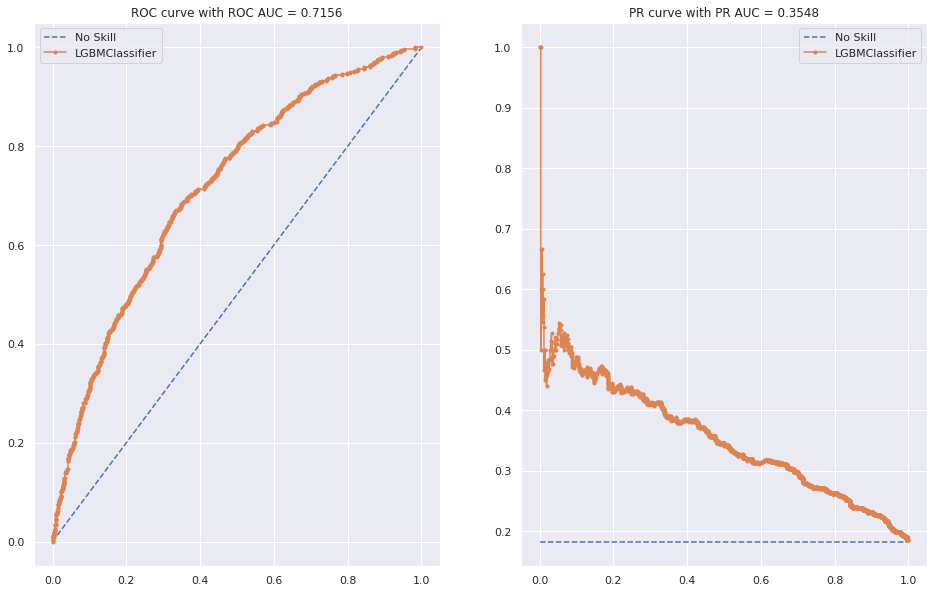

In [ ]:
test_xgb.classification_report(X_test, y_test)

In [ ]:
print(test_xgb.best_params)

{'num_iterations': 763, 'learning_rate': 0.217443616117316, 'max_depth': 2}


In [ ]:
test_lgbm = ModelPreparation(X_undersample_train, y_undersample_train, LGBMClassifier, True)
test_lgbm.tune_params()

[I 2021-12-16 20:16:51,322] A new study created in memory with name: no-name-f89711d1-678d-4008-bfc6-97edab1d173c


kek
kek


[I 2021-12-16 20:17:29,721] Trial 0 finished with value: 0.6222551928783384 and parameters: {'num_iterations': 302, 'learning_rate': 0.9125693769592274, 'max_depth': 9}. Best is trial 0 with value: 0.6222551928783384.


kek


[I 2021-12-16 20:17:50,756] Trial 2 finished with value: 0.6103857566765578 and parameters: {'num_iterations': 110, 'learning_rate': 0.8868855892019959, 'max_depth': 15}. Best is trial 0 with value: 0.6222551928783384.


kek


[I 2021-12-16 20:18:05,668] Trial 1 finished with value: 0.6335311572700296 and parameters: {'num_iterations': 793, 'learning_rate': 0.43539053648885306, 'max_depth': 8}. Best is trial 1 with value: 0.6335311572700296.


kek


[I 2021-12-16 20:18:34,684] Trial 3 finished with value: 0.6299703264094955 and parameters: {'num_iterations': 647, 'learning_rate': 0.8092655610149221, 'max_depth': 12}. Best is trial 1 with value: 0.6335311572700296.


kek


[I 2021-12-16 20:18:51,474] Trial 5 finished with value: 0.623145400593472 and parameters: {'num_iterations': 273, 'learning_rate': 0.3178589010394071, 'max_depth': 4}. Best is trial 1 with value: 0.6335311572700296.


kek


[I 2021-12-16 20:19:19,745] Trial 4 finished with value: 0.627299703264095 and parameters: {'num_iterations': 753, 'learning_rate': 0.3904125618545546, 'max_depth': 15}. Best is trial 1 with value: 0.6335311572700296.


kek


[I 2021-12-16 20:19:59,944] Trial 6 finished with value: 0.6258160237388724 and parameters: {'num_iterations': 597, 'learning_rate': 0.20835327027916617, 'max_depth': 6}. Best is trial 1 with value: 0.6335311572700296.


kek


[I 2021-12-16 20:20:20,971] Trial 7 finished with value: 0.6261127596439169 and parameters: {'num_iterations': 699, 'learning_rate': 0.2530436755121038, 'max_depth': 5}. Best is trial 1 with value: 0.6335311572700296.


kek


[I 2021-12-16 20:20:23,042] Trial 8 finished with value: 0.6175074183976261 and parameters: {'num_iterations': 849, 'learning_rate': 0.6327732657666221, 'max_depth': 2}. Best is trial 1 with value: 0.6335311572700296.


kek


[I 2021-12-16 20:20:41,488] Trial 9 finished with value: 0.6112759643916913 and parameters: {'num_iterations': 109, 'learning_rate': 0.9380117229763221, 'max_depth': 10}. Best is trial 1 with value: 0.6335311572700296.


kek


[I 2021-12-16 20:21:18,497] Trial 10 finished with value: 0.6373887240356084 and parameters: {'num_iterations': 321, 'learning_rate': 0.0268313507661212, 'max_depth': 11}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:22:19,040] Trial 12 finished with value: 0.6329376854599407 and parameters: {'num_iterations': 411, 'learning_rate': 0.028246709416689053, 'max_depth': 8}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:22:56,177] Trial 11 finished with value: 0.6329376854599407 and parameters: {'num_iterations': 929, 'learning_rate': 0.06655161039433527, 'max_depth': 8}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:23:48,644] Trial 14 finished with value: 0.6240356083086054 and parameters: {'num_iterations': 456, 'learning_rate': 0.5044057399786535, 'max_depth': 12}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:24:33,518] Trial 15 finished with value: 0.6290801186943621 and parameters: {'num_iterations': 508, 'learning_rate': 0.6866139226479542, 'max_depth': 12}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:24:55,135] Trial 13 finished with value: 0.6367952522255192 and parameters: {'num_iterations': 918, 'learning_rate': 0.011696597853402213, 'max_depth': 12}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:25:44,995] Trial 16 finished with value: 0.6210682492581603 and parameters: {'num_iterations': 999, 'learning_rate': 0.4710931411878852, 'max_depth': 11}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:26:41,255] Trial 18 finished with value: 0.6311572700296736 and parameters: {'num_iterations': 340, 'learning_rate': 0.1335397860832515, 'max_depth': 14}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:27:19,336] Trial 17 finished with value: 0.6281899109792285 and parameters: {'num_iterations': 990, 'learning_rate': 0.15560944543430244, 'max_depth': 13}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:27:21,989] Trial 19 finished with value: 0.6287833827893176 and parameters: {'num_iterations': 244, 'learning_rate': 0.1324134611530236, 'max_depth': 13}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:27:55,232] Trial 20 finished with value: 0.6332344213649852 and parameters: {'num_iterations': 187, 'learning_rate': 0.02382343347896402, 'max_depth': 16}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:28:48,083] Trial 21 finished with value: 0.6284866468842729 and parameters: {'num_iterations': 511, 'learning_rate': 0.032696184743657104, 'max_depth': 16}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:29:17,445] Trial 22 finished with value: 0.6264094955489614 and parameters: {'num_iterations': 806, 'learning_rate': 0.30038156560651774, 'max_depth': 7}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:30:15,639] Trial 23 finished with value: 0.6335311572700297 and parameters: {'num_iterations': 818, 'learning_rate': 0.2755353515439895, 'max_depth': 7}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:30:16,785] Trial 24 finished with value: 0.6326409495548961 and parameters: {'num_iterations': 875, 'learning_rate': 0.5793372906860168, 'max_depth': 10}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:31:58,486] Trial 26 finished with value: 0.6287833827893176 and parameters: {'num_iterations': 662, 'learning_rate': 0.20440951298183366, 'max_depth': 10}. Best is trial 10 with value: 0.6373887240356084.


kek


[I 2021-12-16 20:32:16,947] Trial 25 finished with value: 0.6379821958456973 and parameters: {'num_iterations': 891, 'learning_rate': 0.18886715352884853, 'max_depth': 10}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:32:42,384] Trial 27 finished with value: 0.627299703264095 and parameters: {'num_iterations': 391, 'learning_rate': 0.10325481938234848, 'max_depth': 6}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:34:41,718] Trial 28 finished with value: 0.6359050445103858 and parameters: {'num_iterations': 919, 'learning_rate': 0.10255222430376598, 'max_depth': 11}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:34:48,720] Trial 29 finished with value: 0.6258160237388725 and parameters: {'num_iterations': 915, 'learning_rate': 0.17997768476711057, 'max_depth': 11}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:36:52,382] Trial 30 finished with value: 0.6359050445103857 and parameters: {'num_iterations': 715, 'learning_rate': 0.007042600845696432, 'max_depth': 11}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:37:11,987] Trial 31 finished with value: 0.6302670623145401 and parameters: {'num_iterations': 734, 'learning_rate': 0.0017360827160316818, 'max_depth': 9}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:39:11,103] Trial 32 finished with value: 0.6311572700296735 and parameters: {'num_iterations': 917, 'learning_rate': 0.09219414440069601, 'max_depth': 9}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:39:41,664] Trial 33 finished with value: 0.6353115727002968 and parameters: {'num_iterations': 927, 'learning_rate': 0.09192657273564588, 'max_depth': 13}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:41:00,427] Trial 35 finished with value: 0.628486646884273 and parameters: {'num_iterations': 874, 'learning_rate': 0.3685315006008539, 'max_depth': 10}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:41:32,396] Trial 34 finished with value: 0.6350148367952522 and parameters: {'num_iterations': 877, 'learning_rate': 0.08393610494514916, 'max_depth': 13}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:42:41,988] Trial 36 finished with value: 0.6320474777448071 and parameters: {'num_iterations': 764, 'learning_rate': 0.2355128224630272, 'max_depth': 14}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:43:11,262] Trial 37 finished with value: 0.6359050445103858 and parameters: {'num_iterations': 786, 'learning_rate': 0.24742255550635342, 'max_depth': 12}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:43:52,553] Trial 38 finished with value: 0.626706231454006 and parameters: {'num_iterations': 596, 'learning_rate': 0.36495980992256727, 'max_depth': 12}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:44:20,895] Trial 40 finished with value: 0.6142433234421366 and parameters: {'num_iterations': 171, 'learning_rate': 0.8133374848131607, 'max_depth': 11}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:44:22,904] Trial 39 finished with value: 0.6270029673590505 and parameters: {'num_iterations': 590, 'learning_rate': 0.35546775422398774, 'max_depth': 12}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:45:44,786] Trial 41 finished with value: 0.6332344213649852 and parameters: {'num_iterations': 779, 'learning_rate': 0.3229189460965848, 'max_depth': 14}. Best is trial 25 with value: 0.6379821958456973.


kek


[I 2021-12-16 20:46:25,425] Trial 42 finished with value: 0.640652818991098 and parameters: {'num_iterations': 957, 'learning_rate': 0.19769690409683452, 'max_depth': 14}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:47:54,265] Trial 43 finished with value: 0.6356083086053411 and parameters: {'num_iterations': 953, 'learning_rate': 0.17701690533144887, 'max_depth': 11}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:48:21,009] Trial 44 finished with value: 0.6332344213649852 and parameters: {'num_iterations': 963, 'learning_rate': 0.21907638722788636, 'max_depth': 15}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:50:24,220] Trial 45 finished with value: 0.6311572700296737 and parameters: {'num_iterations': 965, 'learning_rate': 0.061308646287445305, 'max_depth': 10}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:50:28,880] Trial 46 finished with value: 0.631454005934718 and parameters: {'num_iterations': 846, 'learning_rate': 0.0619831661085506, 'max_depth': 9}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:51:32,379] Trial 47 finished with value: 0.640059347181009 and parameters: {'num_iterations': 658, 'learning_rate': 0.4058466594949585, 'max_depth': 14}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:52:40,743] Trial 49 finished with value: 0.629673590504451 and parameters: {'num_iterations': 660, 'learning_rate': 0.40748028528046765, 'max_depth': 15}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:52:51,376] Trial 48 finished with value: 0.6314540059347181 and parameters: {'num_iterations': 894, 'learning_rate': 0.1448266784727223, 'max_depth': 14}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:53:17,170] Trial 50 finished with value: 0.6195845697329376 and parameters: {'num_iterations': 528, 'learning_rate': 0.9976973688059831, 'max_depth': 14}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:53:35,788] Trial 51 finished with value: 0.6311572700296737 and parameters: {'num_iterations': 333, 'learning_rate': 0.5708572619963349, 'max_depth': 13}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:54:26,167] Trial 52 finished with value: 0.6270029673590505 and parameters: {'num_iterations': 839, 'learning_rate': 0.4518102347438675, 'max_depth': 13}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:55:48,514] Trial 53 finished with value: 0.6350148367952523 and parameters: {'num_iterations': 831, 'learning_rate': 0.11315364404427836, 'max_depth': 11}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:55:56,339] Trial 54 finished with value: 0.6308605341246291 and parameters: {'num_iterations': 682, 'learning_rate': 0.26983827703925756, 'max_depth': 12}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:56:36,868] Trial 56 finished with value: 0.6246290801186943 and parameters: {'num_iterations': 995, 'learning_rate': 0.17396682498856517, 'max_depth': 3}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:57:08,396] Trial 55 finished with value: 0.6243323442136499 and parameters: {'num_iterations': 476, 'learning_rate': 0.04759997452924302, 'max_depth': 15}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:58:01,631] Trial 58 finished with value: 0.6201780415430267 and parameters: {'num_iterations': 947, 'learning_rate': 0.7071398594011438, 'max_depth': 8}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:58:53,233] Trial 57 finished with value: 0.6353115727002968 and parameters: {'num_iterations': 949, 'learning_rate': 0.05674059236588505, 'max_depth': 8}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:59:11,107] Trial 59 finished with value: 0.6317507418397627 and parameters: {'num_iterations': 419, 'learning_rate': 0.12710514063517664, 'max_depth': 16}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 20:59:55,635] Trial 60 finished with value: 0.6302670623145401 and parameters: {'num_iterations': 779, 'learning_rate': 0.5205560718595185, 'max_depth': 16}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:00:48,987] Trial 61 finished with value: 0.6308605341246291 and parameters: {'num_iterations': 749, 'learning_rate': 0.25098853438131374, 'max_depth': 12}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:01:54,843] Trial 62 finished with value: 0.6376854599406527 and parameters: {'num_iterations': 897, 'learning_rate': 0.20406901353189436, 'max_depth': 12}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:02:20,187] Trial 63 finished with value: 0.6370919881305638 and parameters: {'num_iterations': 889, 'learning_rate': 0.3036217935028867, 'max_depth': 10}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:03:26,574] Trial 64 finished with value: 0.6388724035608309 and parameters: {'num_iterations': 896, 'learning_rate': 0.3019959293403871, 'max_depth': 10}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:03:51,127] Trial 65 finished with value: 0.6320474777448071 and parameters: {'num_iterations': 894, 'learning_rate': 0.3057545354168918, 'max_depth': 10}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:04:37,430] Trial 67 finished with value: 0.6278931750741841 and parameters: {'num_iterations': 278, 'learning_rate': 0.33563030195884813, 'max_depth': 10}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:04:44,919] Trial 66 finished with value: 0.6281899109792286 and parameters: {'num_iterations': 622, 'learning_rate': 0.31455025889369753, 'max_depth': 10}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:05:39,274] Trial 68 finished with value: 0.6338278931750743 and parameters: {'num_iterations': 620, 'learning_rate': 0.4107084248060224, 'max_depth': 7}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:06:13,773] Trial 69 finished with value: 0.6341246290801187 and parameters: {'num_iterations': 862, 'learning_rate': 0.2804757777910273, 'max_depth': 7}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:07:34,429] Trial 70 finished with value: 0.63026706231454 and parameters: {'num_iterations': 860, 'learning_rate': 0.1995539070876405, 'max_depth': 9}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:08:02,535] Trial 71 finished with value: 0.6299703264094955 and parameters: {'num_iterations': 805, 'learning_rate': 0.21205152211556638, 'max_depth': 9}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:09:21,122] Trial 73 finished with value: 0.6311572700296735 and parameters: {'num_iterations': 900, 'learning_rate': 0.38513748261161695, 'max_depth': 11}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:09:25,067] Trial 72 finished with value: 0.6281899109792286 and parameters: {'num_iterations': 900, 'learning_rate': 0.22485551336167048, 'max_depth': 11}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:10:32,152] Trial 74 finished with value: 0.6335311572700296 and parameters: {'num_iterations': 975, 'learning_rate': 0.4758427116641841, 'max_depth': 12}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:11:50,357] Trial 75 finished with value: 0.6362017804154303 and parameters: {'num_iterations': 984, 'learning_rate': 0.15351862632904478, 'max_depth': 13}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:12:43,827] Trial 76 finished with value: 0.6376854599406528 and parameters: {'num_iterations': 821, 'learning_rate': 0.15617566216419057, 'max_depth': 13}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:13:27,923] Trial 77 finished with value: 0.6344213649851632 and parameters: {'num_iterations': 937, 'learning_rate': 0.2794080506636597, 'max_depth': 11}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:14:03,053] Trial 78 finished with value: 0.6290801186943621 and parameters: {'num_iterations': 721, 'learning_rate': 0.34128311358502633, 'max_depth': 14}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:15:25,670] Trial 79 finished with value: 0.6344213649851632 and parameters: {'num_iterations': 813, 'learning_rate': 0.19270695537197596, 'max_depth': 15}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:16:04,709] Trial 80 finished with value: 0.6329376854599407 and parameters: {'num_iterations': 813, 'learning_rate': 0.18212715270165453, 'max_depth': 15}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:16:56,851] Trial 81 finished with value: 0.638872403560831 and parameters: {'num_iterations': 558, 'learning_rate': 0.1598448732035648, 'max_depth': 13}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:18:26,892] Trial 82 finished with value: 0.6323442136498516 and parameters: {'num_iterations': 924, 'learning_rate': 0.14825054116966285, 'max_depth': 12}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:18:29,499] Trial 83 finished with value: 0.627893175074184 and parameters: {'num_iterations': 566, 'learning_rate': 0.1586918744641907, 'max_depth': 13}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:19:47,906] Trial 85 finished with value: 0.6281899109792286 and parameters: {'num_iterations': 476, 'learning_rate': 0.25659045448938284, 'max_depth': 13}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:19:54,328] Trial 84 finished with value: 0.6255192878338279 and parameters: {'num_iterations': 545, 'learning_rate': 0.2390520373907513, 'max_depth': 13}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:20:30,511] Trial 87 finished with value: 0.6264094955489614 and parameters: {'num_iterations': 211, 'learning_rate': 0.2977933252546076, 'max_depth': 14}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:21:18,262] Trial 86 finished with value: 0.6311572700296736 and parameters: {'num_iterations': 566, 'learning_rate': 0.23224123626031268, 'max_depth': 14}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:21:41,335] Trial 89 finished with value: 0.6376854599406528 and parameters: {'num_iterations': 139, 'learning_rate': 0.1126178613213695, 'max_depth': 10}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:22:00,443] Trial 90 finished with value: 0.6335311572700297 and parameters: {'num_iterations': 107, 'learning_rate': 0.09543089180123075, 'max_depth': 12}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:22:23,880] Trial 88 finished with value: 0.6356083086053413 and parameters: {'num_iterations': 694, 'learning_rate': 0.12318942217945839, 'max_depth': 14}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:22:25,200] Trial 91 finished with value: 0.6347181008902077 and parameters: {'num_iterations': 130, 'learning_rate': 0.033921792335786086, 'max_depth': 11}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:22:47,702] Trial 92 finished with value: 0.6311572700296736 and parameters: {'num_iterations': 145, 'learning_rate': 0.12815679061250052, 'max_depth': 10}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:23:23,837] Trial 94 finished with value: 0.6317507418397627 and parameters: {'num_iterations': 232, 'learning_rate': 0.07685049573707127, 'max_depth': 9}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:23:25,170] Trial 93 finished with value: 0.6367952522255192 and parameters: {'num_iterations': 382, 'learning_rate': 0.08035778952781353, 'max_depth': 10}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:25:28,096] Trial 96 finished with value: 0.6391691394658754 and parameters: {'num_iterations': 885, 'learning_rate': 0.17716714990369836, 'max_depth': 9}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:25:31,876] Trial 95 finished with value: 0.6367952522255192 and parameters: {'num_iterations': 874, 'learning_rate': 0.16774427787875218, 'max_depth': 10}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:27:21,768] Trial 98 finished with value: 0.6362017804154303 and parameters: {'num_iterations': 838, 'learning_rate': 0.1980869664033001, 'max_depth': 8}. Best is trial 42 with value: 0.640652818991098.


kek


[I 2021-12-16 21:27:28,227] Trial 97 finished with value: 0.6356083086053413 and parameters: {'num_iterations': 859, 'learning_rate': 0.16704649780677147, 'max_depth': 8}. Best is trial 42 with value: 0.640652818991098.
[I 2021-12-16 21:27:57,489] Trial 99 finished with value: 0.6326409495548961 and parameters: {'num_iterations': 336, 'learning_rate': 0.021393273727193268, 'max_depth': 9}. Best is trial 42 with value: 0.640652818991098.


Best score: 0.640652818991098



Classification report for LGBMClassifier:
F0.5 score = 0.5961
F1 score = 0.6115
F2 score = 0.6278
recall score = 0.6391
precision score = 0.5862
Accuracy on balanced class data = 0.6157


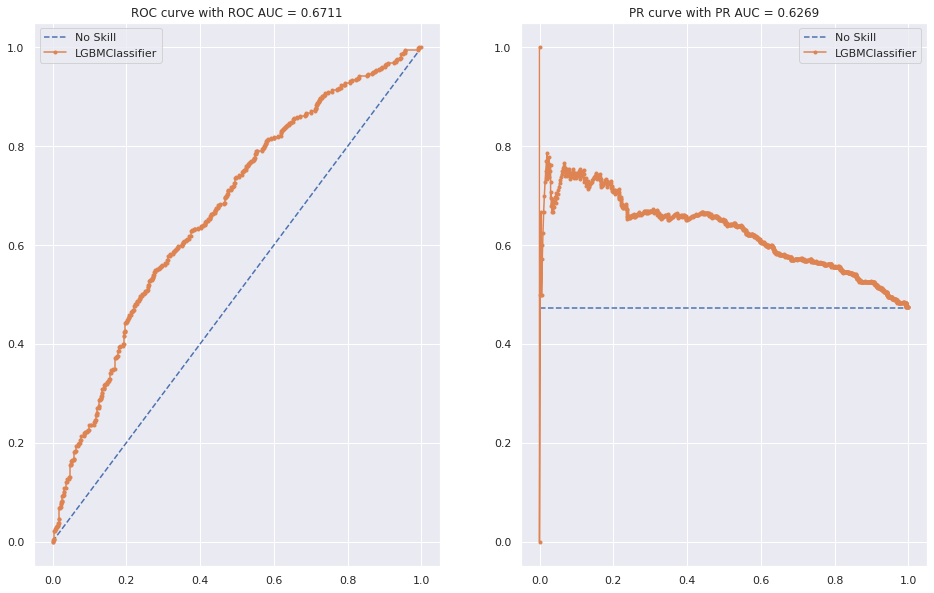

In [ ]:
test_lgbm.classification_report(X_undersample_test, y_undersample_test, True)

In [ ]:
print(test_lgbm.best_params)

{'num_iterations': 957, 'learning_rate': 0.19769690409683452, 'max_depth': 14}


In [ ]:
test_lgbmfull = ModelPreparation(X_train, y_train, LGBMClassifier)
test_lgbmfull.tune_params()

[I 2021-12-16 19:12:49,067] A new study created in memory with name: no-name-1042942a-cc7d-4520-acd0-5de9230bb690


kek
kek


[I 2021-12-16 19:13:21,931] Trial 1 finished with value: 0.7745673645305128 and parameters: {'num_iterations': 152, 'learning_rate': 0.44304807245680267, 'max_depth': 8}. Best is trial 1 with value: 0.7745673645305128.


kek


[I 2021-12-16 19:14:28,680] Trial 0 finished with value: 0.7706957162889069 and parameters: {'num_iterations': 711, 'learning_rate': 0.7511577682119778, 'max_depth': 15}. Best is trial 1 with value: 0.7745673645305128.


kek


[I 2021-12-16 19:14:52,219] Trial 2 finished with value: 0.7661994862868378 and parameters: {'num_iterations': 803, 'learning_rate': 0.9440826966554564, 'max_depth': 10}. Best is trial 1 with value: 0.7745673645305128.


kek


[I 2021-12-16 19:15:16,983] Trial 4 finished with value: 0.7648320569768131 and parameters: {'num_iterations': 103, 'learning_rate': 0.7020476972131765, 'max_depth': 9}. Best is trial 1 with value: 0.7745673645305128.


kek


[I 2021-12-16 19:16:57,833] Trial 5 finished with value: 0.7717660562363153 and parameters: {'num_iterations': 614, 'learning_rate': 0.6151901271252942, 'max_depth': 8}. Best is trial 1 with value: 0.7745673645305128.


kek


[I 2021-12-16 19:17:05,995] Trial 3 finished with value: 0.7680616253330425 and parameters: {'num_iterations': 938, 'learning_rate': 0.017453263592715918, 'max_depth': 6}. Best is trial 1 with value: 0.7745673645305128.


kek


[I 2021-12-16 19:18:17,182] Trial 6 finished with value: 0.7607874742710121 and parameters: {'num_iterations': 538, 'learning_rate': 0.934946520329236, 'max_depth': 10}. Best is trial 1 with value: 0.7745673645305128.


kek


[I 2021-12-16 19:18:59,121] Trial 7 finished with value: 0.7750123191472227 and parameters: {'num_iterations': 930, 'learning_rate': 0.817602251942007, 'max_depth': 7}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:20:28,873] Trial 8 finished with value: 0.7706319576219192 and parameters: {'num_iterations': 846, 'learning_rate': 0.502679820890114, 'max_depth': 12}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:20:33,211] Trial 9 finished with value: 0.7711530247228706 and parameters: {'num_iterations': 690, 'learning_rate': 0.25562525388737867, 'max_depth': 5}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:20:54,188] Trial 11 finished with value: 0.764022890265467 and parameters: {'num_iterations': 401, 'learning_rate': 0.8448850764354117, 'max_depth': 2}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:21:13,736] Trial 12 finished with value: 0.7729601011035004 and parameters: {'num_iterations': 129, 'learning_rate': 0.32522497751043994, 'max_depth': 5}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:21:33,744] Trial 13 finished with value: 0.7744331061064138 and parameters: {'num_iterations': 362, 'learning_rate': 0.3829148333328416, 'max_depth': 2}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:21:39,420] Trial 10 finished with value: 0.6959662667085883 and parameters: {'num_iterations': 448, 'learning_rate': 0.9353760900949959, 'max_depth': 11}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:22:29,498] Trial 14 finished with value: 0.773277142436189 and parameters: {'num_iterations': 269, 'learning_rate': 0.5392914031262512, 'max_depth': 7}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:22:34,386] Trial 15 finished with value: 0.7713347075083498 and parameters: {'num_iterations': 265, 'learning_rate': 0.5230717435569432, 'max_depth': 7}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:25:53,604] Trial 16 finished with value: 0.7674029147039706 and parameters: {'num_iterations': 952, 'learning_rate': 0.16181238057385794, 'max_depth': 13}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:25:59,048] Trial 17 finished with value: 0.7724210884220202 and parameters: {'num_iterations': 957, 'learning_rate': 0.20915352940282167, 'max_depth': 13}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:26:47,308] Trial 18 finished with value: 0.7701524957928576 and parameters: {'num_iterations': 531, 'learning_rate': 0.6741697456799891, 'max_depth': 4}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:26:51,041] Trial 19 finished with value: 0.7721287190709846 and parameters: {'num_iterations': 527, 'learning_rate': 0.4004356462125251, 'max_depth': 4}. Best is trial 7 with value: 0.7750123191472227.


kek


[I 2021-12-16 19:27:44,934] Trial 20 finished with value: 0.7757502031016474 and parameters: {'num_iterations': 273, 'learning_rate': 0.3724229643923447, 'max_depth': 8}. Best is trial 20 with value: 0.7757502031016474.


kek


[I 2021-12-16 19:27:46,190] Trial 21 finished with value: 0.7655634985878275 and parameters: {'num_iterations': 229, 'learning_rate': 0.8226182910670383, 'max_depth': 16}. Best is trial 20 with value: 0.7757502031016474.


kek


[I 2021-12-16 19:28:34,498] Trial 23 finished with value: 0.7732422396628501 and parameters: {'num_iterations': 218, 'learning_rate': 0.43276190255889785, 'max_depth': 9}. Best is trial 20 with value: 0.7757502031016474.


kek


[I 2021-12-16 19:28:35,061] Trial 22 finished with value: 0.7732513159257935 and parameters: {'num_iterations': 233, 'learning_rate': 0.42946281932742747, 'max_depth': 8}. Best is trial 20 with value: 0.7757502031016474.


kek


[I 2021-12-16 19:29:42,405] Trial 25 finished with value: 0.7679784073381601 and parameters: {'num_iterations': 342, 'learning_rate': 0.3042167698610032, 'max_depth': 7}. Best is trial 20 with value: 0.7757502031016474.


kek


[I 2021-12-16 19:29:47,716] Trial 24 finished with value: 0.7694943640271619 and parameters: {'num_iterations': 345, 'learning_rate': 0.5996691549864701, 'max_depth': 8}. Best is trial 20 with value: 0.7757502031016474.


kek


[I 2021-12-16 19:30:16,912] Trial 27 finished with value: 0.7709947326980899 and parameters: {'num_iterations': 161, 'learning_rate': 0.10874006532872332, 'max_depth': 6}. Best is trial 20 with value: 0.7757502031016474.


kek


[I 2021-12-16 19:31:13,386] Trial 26 finished with value: 0.770836532727049 and parameters: {'num_iterations': 458, 'learning_rate': 0.5988077987560249, 'max_depth': 9}. Best is trial 20 with value: 0.7757502031016474.


kek


[I 2021-12-16 19:32:01,431] Trial 28 finished with value: 0.7707532819853213 and parameters: {'num_iterations': 475, 'learning_rate': 0.3412898055965269, 'max_depth': 10}. Best is trial 20 with value: 0.7757502031016474.


kek


[I 2021-12-16 19:33:27,165] Trial 30 finished with value: 0.7694945297273269 and parameters: {'num_iterations': 640, 'learning_rate': 0.7899800033146128, 'max_depth': 6}. Best is trial 20 with value: 0.7757502031016474.


kek


[I 2021-12-16 19:33:27,548] Trial 29 finished with value: 0.7726940448241143 and parameters: {'num_iterations': 620, 'learning_rate': 0.3460640655632548, 'max_depth': 11}. Best is trial 20 with value: 0.7757502031016474.


kek


[I 2021-12-16 19:33:44,601] Trial 32 finished with value: 0.77433938873504 and parameters: {'num_iterations': 320, 'learning_rate': 0.444891256658163, 'max_depth': 2}. Best is trial 20 with value: 0.7757502031016474.


kek


[I 2021-12-16 19:33:58,133] Trial 33 finished with value: 0.7763115761477911 and parameters: {'num_iterations': 176, 'learning_rate': 0.24811727235336495, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:34:17,594] Trial 34 finished with value: 0.7721137913519054 and parameters: {'num_iterations': 186, 'learning_rate': 0.13380629054939422, 'max_depth': 4}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:35:13,589] Trial 35 finished with value: 0.7744324797995387 and parameters: {'num_iterations': 822, 'learning_rate': 0.25192743823007646, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:35:39,658] Trial 31 finished with value: 0.7738244309205402 and parameters: {'num_iterations': 779, 'learning_rate': 0.46694280362623003, 'max_depth': 11}. Best is trial 33 with value: 0.7763115761477911.
[I 2021-12-16 19:35:39,750] Trial 36 finished with value: 0.7601968710116863 and parameters: {'num_iterations': 100, 'learning_rate': 0.03025831647455013, 'max_depth': 8}. Best is trial 33 with value: 0.7763115761477911.


kek
kek


[I 2021-12-16 19:36:01,800] Trial 37 finished with value: 0.7670614736062299 and parameters: {'num_iterations': 106, 'learning_rate': 0.9941783566732256, 'max_depth': 6}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:36:17,107] Trial 38 finished with value: 0.7734501945243404 and parameters: {'num_iterations': 171, 'learning_rate': 0.2621297731794097, 'max_depth': 9}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:36:58,709] Trial 40 finished with value: 0.7681589335638543 and parameters: {'num_iterations': 289, 'learning_rate': 0.5478132643998049, 'max_depth': 5}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:37:50,692] Trial 41 finished with value: 0.7711862687931392 and parameters: {'num_iterations': 747, 'learning_rate': 0.708743507662835, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:38:18,402] Trial 42 finished with value: 0.7724321404343715 and parameters: {'num_iterations': 388, 'learning_rate': 0.3768367705255731, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:38:57,506] Trial 39 finished with value: 0.7724747394144422 and parameters: {'num_iterations': 892, 'learning_rate': 0.28342221830072506, 'max_depth': 9}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:39:00,799] Trial 43 finished with value: 0.7717815203548278 and parameters: {'num_iterations': 859, 'learning_rate': 0.3922730351543902, 'max_depth': 2}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:39:06,787] Trial 44 finished with value: 0.7720604000584667 and parameters: {'num_iterations': 153, 'learning_rate': 0.38274977102334723, 'max_depth': 2}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:39:54,751] Trial 45 finished with value: 0.7744611376040607 and parameters: {'num_iterations': 380, 'learning_rate': 0.47294369091936317, 'max_depth': 5}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:40:24,445] Trial 46 finished with value: 0.7702074567501364 and parameters: {'num_iterations': 387, 'learning_rate': 0.4907950703386093, 'max_depth': 7}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:41:05,845] Trial 48 finished with value: 0.7693430940566016 and parameters: {'num_iterations': 301, 'learning_rate': 0.206882973014489, 'max_depth': 5}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:41:51,570] Trial 49 finished with value: 0.7689961196331996 and parameters: {'num_iterations': 203, 'learning_rate': 0.660094912535699, 'max_depth': 8}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:42:07,464] Trial 47 finished with value: 0.7710997118363315 and parameters: {'num_iterations': 993, 'learning_rate': 0.19763732059054517, 'max_depth': 5}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:42:43,511] Trial 50 finished with value: 0.7733546745381734 and parameters: {'num_iterations': 250, 'learning_rate': 0.562663436572229, 'max_depth': 7}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:42:59,332] Trial 51 finished with value: 0.7693838942592961 and parameters: {'num_iterations': 245, 'learning_rate': 0.8950384249388785, 'max_depth': 7}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:43:12,829] Trial 52 finished with value: 0.7731311134179327 and parameters: {'num_iterations': 407, 'learning_rate': 0.49387228006006073, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:43:25,090] Trial 53 finished with value: 0.7705308733831386 and parameters: {'num_iterations': 357, 'learning_rate': 0.47732759470413666, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:44:09,084] Trial 54 finished with value: 0.7732629030191949 and parameters: {'num_iterations': 572, 'learning_rate': 0.34668649304240096, 'max_depth': 4}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:44:13,965] Trial 55 finished with value: 0.7717716701534603 and parameters: {'num_iterations': 498, 'learning_rate': 0.3460609812842567, 'max_depth': 4}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:45:31,500] Trial 57 finished with value: 0.7687943188063849 and parameters: {'num_iterations': 432, 'learning_rate': 0.5190963619025168, 'max_depth': 6}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:45:36,012] Trial 56 finished with value: 0.7717835837288779 and parameters: {'num_iterations': 488, 'learning_rate': 0.44249274830158264, 'max_depth': 6}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:46:05,132] Trial 58 finished with value: 0.7680883668610019 and parameters: {'num_iterations': 147, 'learning_rate': 0.4196680382298015, 'max_depth': 10}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:46:05,471] Trial 59 finished with value: 0.7717501289112576 and parameters: {'num_iterations': 137, 'learning_rate': 0.2821630908641551, 'max_depth': 8}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:46:34,916] Trial 61 finished with value: 0.7726630037835862 and parameters: {'num_iterations': 285, 'learning_rate': 0.629126950701923, 'max_depth': 4}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:47:37,108] Trial 62 finished with value: 0.7736592270542115 and parameters: {'num_iterations': 914, 'learning_rate': 0.26647575855896977, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:48:17,826] Trial 63 finished with value: 0.7727293559017607 and parameters: {'num_iterations': 822, 'learning_rate': 0.23539435861041622, 'max_depth': 2}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:48:24,258] Trial 60 finished with value: 0.7722913844428106 and parameters: {'num_iterations': 684, 'learning_rate': 0.3100735768647671, 'max_depth': 8}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:48:33,215] Trial 64 finished with value: 0.7727403672621846 and parameters: {'num_iterations': 201, 'learning_rate': 0.18352516505340682, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:48:40,195] Trial 65 finished with value: 0.7681855069544506 and parameters: {'num_iterations': 203, 'learning_rate': 0.0921062613439817, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:48:50,075] Trial 66 finished with value: 0.7643316784818608 and parameters: {'num_iterations': 312, 'learning_rate': 0.08831734812540049, 'max_depth': 2}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:49:39,690] Trial 68 finished with value: 0.7752739115636286 and parameters: {'num_iterations': 361, 'learning_rate': 0.2276595706549258, 'max_depth': 5}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:50:51,355] Trial 67 finished with value: 0.7715277796299912 and parameters: {'num_iterations': 1000, 'learning_rate': 0.3748351291535698, 'max_depth': 5}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:50:53,937] Trial 69 finished with value: 0.770824541788655 and parameters: {'num_iterations': 368, 'learning_rate': 0.45771433015583046, 'max_depth': 7}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:51:57,217] Trial 70 finished with value: 0.7706132030375387 and parameters: {'num_iterations': 366, 'learning_rate': 0.4557644510492074, 'max_depth': 6}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:52:09,092] Trial 71 finished with value: 0.7740467555513668 and parameters: {'num_iterations': 418, 'learning_rate': 0.4108428697684937, 'max_depth': 6}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:52:29,049] Trial 72 finished with value: 0.771991703317511 and parameters: {'num_iterations': 322, 'learning_rate': 0.14580469006845254, 'max_depth': 4}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:53:03,413] Trial 73 finished with value: 0.7732023428072642 and parameters: {'num_iterations': 567, 'learning_rate': 0.1563087828175569, 'max_depth': 4}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:53:58,955] Trial 75 finished with value: 0.7710926713541637 and parameters: {'num_iterations': 260, 'learning_rate': 0.23351172420469452, 'max_depth': 9}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:55:11,292] Trial 76 finished with value: 0.7697210512856408 and parameters: {'num_iterations': 332, 'learning_rate': 0.3199982323094773, 'max_depth': 10}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:55:30,965] Trial 74 finished with value: 0.7726388327579292 and parameters: {'num_iterations': 892, 'learning_rate': 0.24321257445822514, 'max_depth': 9}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:55:56,801] Trial 78 finished with value: 0.767305719311735 and parameters: {'num_iterations': 174, 'learning_rate': 0.5732425772293408, 'max_depth': 5}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:56:19,913] Trial 79 finished with value: 0.7646236311793982 and parameters: {'num_iterations': 447, 'learning_rate': 0.7588861709216509, 'max_depth': 2}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:57:08,803] Trial 77 finished with value: 0.7736109601526767 and parameters: {'num_iterations': 868, 'learning_rate': 0.24545064285928675, 'max_depth': 5}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:57:16,815] Trial 80 finished with value: 0.7686055170651974 and parameters: {'num_iterations': 274, 'learning_rate': 0.29235342959547583, 'max_depth': 8}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:57:29,342] Trial 82 finished with value: 0.7761245590080421 and parameters: {'num_iterations': 223, 'learning_rate': 0.5165794605386962, 'max_depth': 2}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:57:37,147] Trial 83 finished with value: 0.7695333564915586 and parameters: {'num_iterations': 124, 'learning_rate': 0.36753241853548435, 'max_depth': 2}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 19:57:54,370] Trial 84 finished with value: 0.7648155548637431 and parameters: {'num_iterations': 227, 'learning_rate': 0.866802804508934, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:00:15,532] Trial 81 finished with value: 0.7708706006062745 and parameters: {'num_iterations': 965, 'learning_rate': 0.2907288443553091, 'max_depth': 14}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:00:54,589] Trial 86 finished with value: 0.7697208510333683 and parameters: {'num_iterations': 788, 'learning_rate': 0.5136967362415272, 'max_depth': 2}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:01:09,131] Trial 87 finished with value: 0.7693510343855277 and parameters: {'num_iterations': 190, 'learning_rate': 0.17689816398993113, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:01:16,217] Trial 85 finished with value: 0.7657834060359157 and parameters: {'num_iterations': 931, 'learning_rate': 0.18631902845407572, 'max_depth': 14}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:01:53,248] Trial 88 finished with value: 0.7589182207823507 and parameters: {'num_iterations': 224, 'learning_rate': 0.9918620374930605, 'max_depth': 7}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:02:08,938] Trial 90 finished with value: 0.7722042745015315 and parameters: {'num_iterations': 294, 'learning_rate': 0.22215340020972704, 'max_depth': 2}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:02:34,046] Trial 89 finished with value: 0.7668465992778545 and parameters: {'num_iterations': 387, 'learning_rate': 0.40055777616836336, 'max_depth': 7}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:02:52,501] Trial 92 finished with value: 0.7739212292127874 and parameters: {'num_iterations': 344, 'learning_rate': 0.43125580222355075, 'max_depth': 2}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:03:15,423] Trial 93 finished with value: 0.7736810976629279 and parameters: {'num_iterations': 314, 'learning_rate': 0.5415550268961417, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:03:23,294] Trial 91 finished with value: 0.7697088549035944 and parameters: {'num_iterations': 749, 'learning_rate': 0.5334634752558043, 'max_depth': 4}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:03:29,075] Trial 94 finished with value: 0.7731239169226183 and parameters: {'num_iterations': 246, 'learning_rate': 0.48178466586623125, 'max_depth': 2}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:03:41,207] Trial 95 finished with value: 0.7735345697420221 and parameters: {'num_iterations': 241, 'learning_rate': 0.33205171327578975, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:03:42,472] Trial 96 finished with value: 0.7730564880439253 and parameters: {'num_iterations': 171, 'learning_rate': 0.34111634466503177, 'max_depth': 3}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:03:57,125] Trial 98 finished with value: 0.7739572223054318 and parameters: {'num_iterations': 271, 'learning_rate': 0.3635475504886375, 'max_depth': 2}. Best is trial 33 with value: 0.7763115761477911.


kek


[I 2021-12-16 20:04:24,381] Trial 99 finished with value: 0.7689469414331317 and parameters: {'num_iterations': 121, 'learning_rate': 0.5034118874482478, 'max_depth': 8}. Best is trial 33 with value: 0.7763115761477911.
[I 2021-12-16 20:04:31,394] Trial 97 finished with value: 0.7730683134731572 and parameters: {'num_iterations': 266, 'learning_rate': 0.44853080972059683, 'max_depth': 8}. Best is trial 33 with value: 0.7763115761477911.


Best score: 0.7763115761477911



Classification report for LGBMClassifier:
F0.5 score = 0.3224
F1 score = 0.2069
F2 score = 0.1523
recall score = 0.1295
precision score = 0.5137


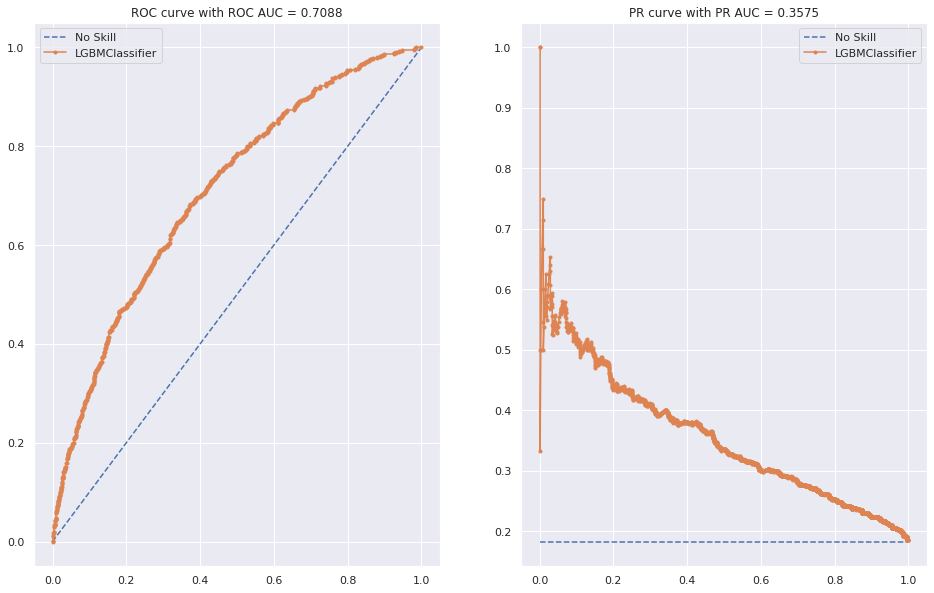

In [ ]:
test_lgbmfull.classification_report(X_test, y_test, True)

In [ ]:
print(test_lgbmfull.best_params)

{'num_iterations': 176, 'learning_rate': 0.24811727235336495, 'max_depth': 3}
